# Comparing Segmentation and Perturbation Methods

This notebook compares different segmentation and perturbation methods for trajectory explanation.


In [2]:
import warnings

warnings.filterwarnings('ignore', category=Warning)

In [3]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pactus import Dataset
from pactus.models import LSTMModel

# Import from the traj-xai package
from traj_xai.src import (
    rdp_segmentation,
    mdl_segmentation,
    sliding_window_segmentation,
    random_segmentation,
    gaussian_perturbation,
    scaling_perturbation,
    rotation_perturbation,
    gan_perturbation,
    run_experiments,
)

## Load and Prepare Data


In [5]:
# Set a random seed for reproducibility
SEED = 0

# Load the UCI Movement Libras dataset (smaller dataset for demonstration)
dataset = Dataset.uci_movement_libras()
print(f"Dataset loaded: {len(dataset.trajs)} trajectories")

# Split data into train and test subsets
train, test = dataset.split(0.8, random_state=SEED)
print(f"Train set: {len(train.trajs)} trajectories")
print(f"Test set: {len(test.trajs)} trajectories")

# Take a small subset for quicker demonstration
small_test = test.take(5, stratify=False, random_state=SEED)
print(f"Small test set: {len(small_test.trajs)} trajectories")

Dataset loaded: 360 trajectories
Train set: 288 trajectories
Test set: 72 trajectories
Small test set: 5 trajectories


## Train a Black Box Model


In [5]:
# Build and train the model
model = LSTMModel(random_state=SEED)

# Train the model on the train dataset (with fewer epochs for demo)
model.train(train, dataset, epochs=5, batch_size=64)

# Evaluate the model on the test dataset
evaluation = model.evaluate(test)
evaluation.show()

12:39:36 [WARNING] Custom seed provided for lstm model. This calls 'tf.keras.utils.set_random_seed' which sets a global random state on python, numpy and tensorflow.


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.0625 - loss: 2.7154
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0625 - loss: 2.7193
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0417 - loss: 2.7161
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0625 - loss: 2.7112
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0590 - loss: 2.7094 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step

General statistics:

Accuracy: 0.056
F1-score: 0.007
Mean precision: 0.004
Mean recall: 0.067

Confusion matrix:

anti-clockwise arc        circle                    clockwise arc             curved swing              face-down curve           face-up curve             horizontal straight-line  horizontal swing          horizontal wavy           horizontal zigzag         tremble                   vertical straight-line    vertical swing            vertical wavy             vertical zigzag           precision                 
0.0               

## Compare Different Segmentation Methods


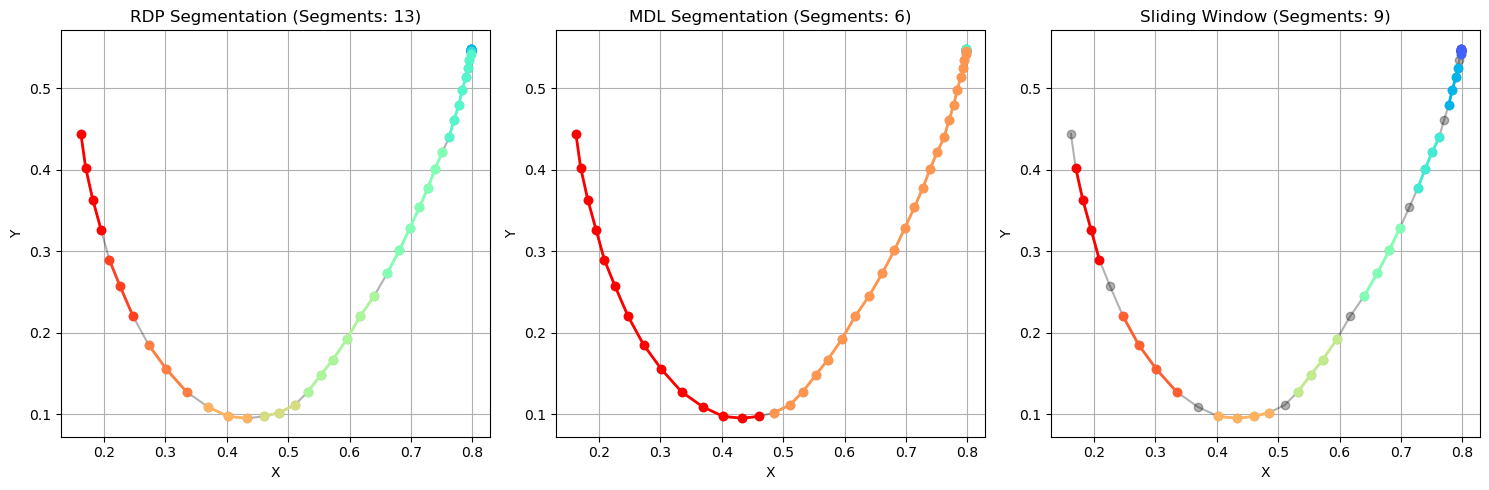

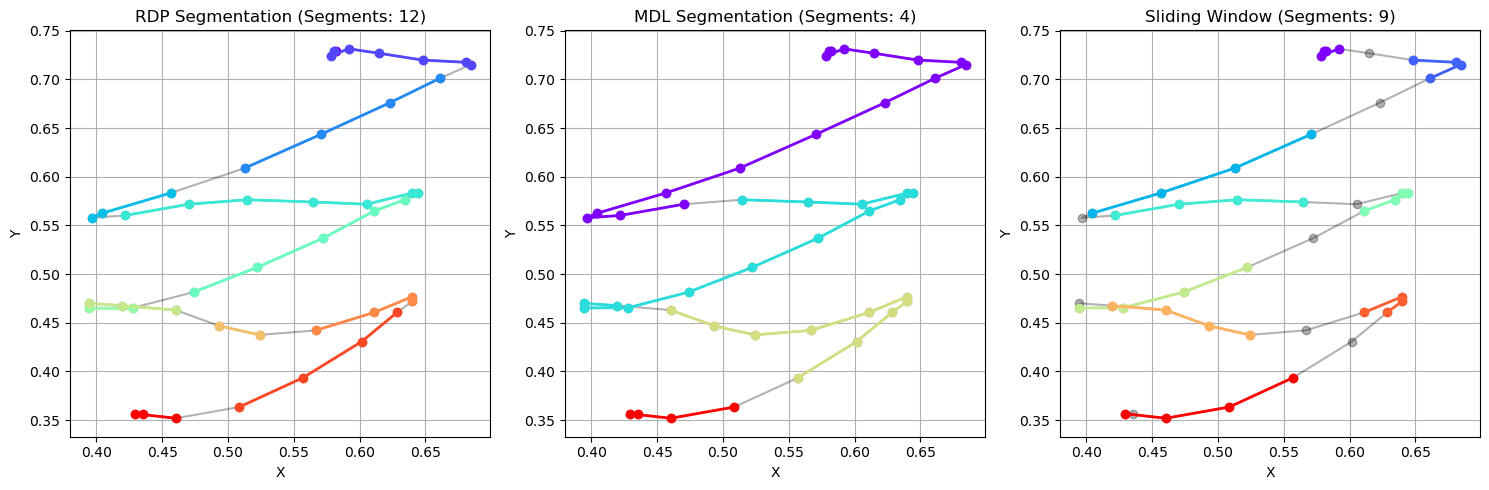

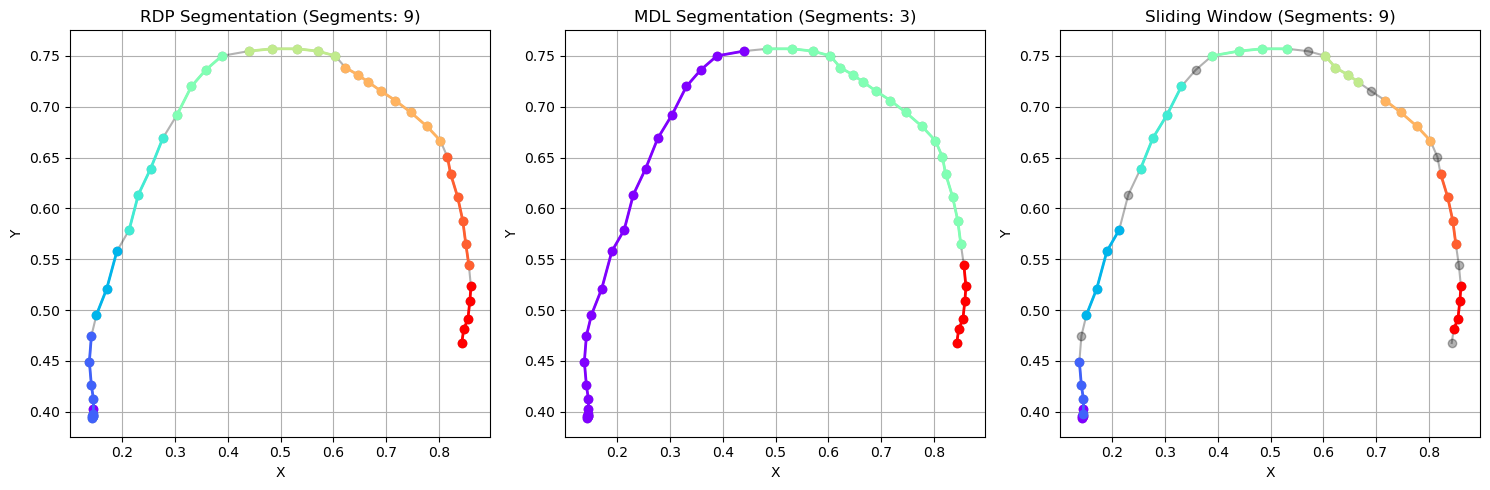

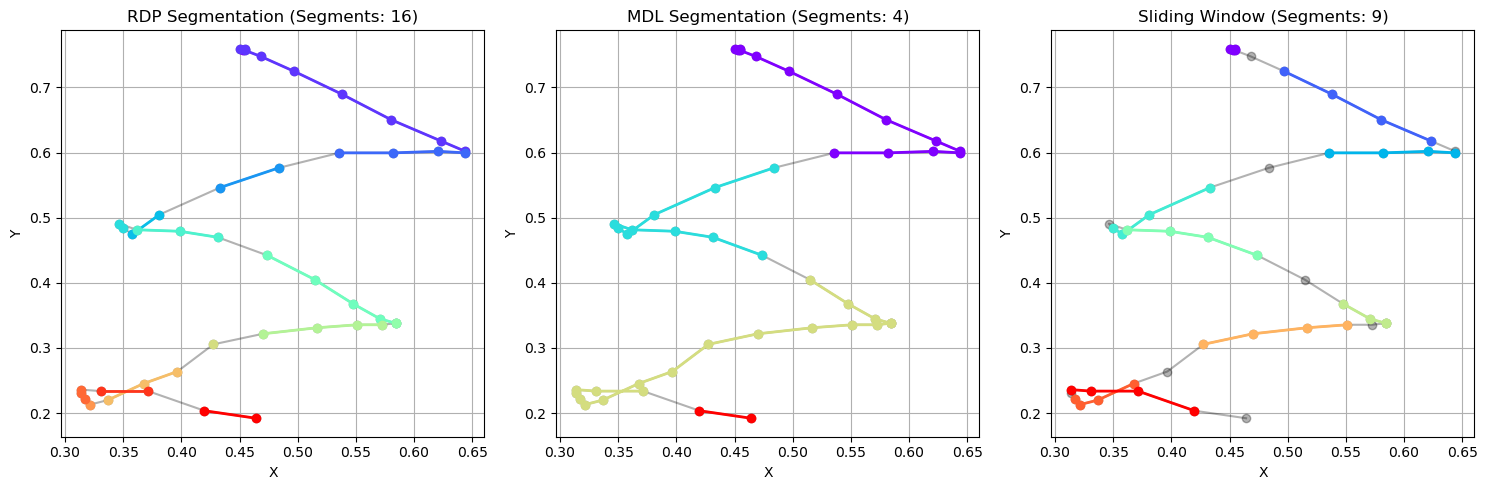

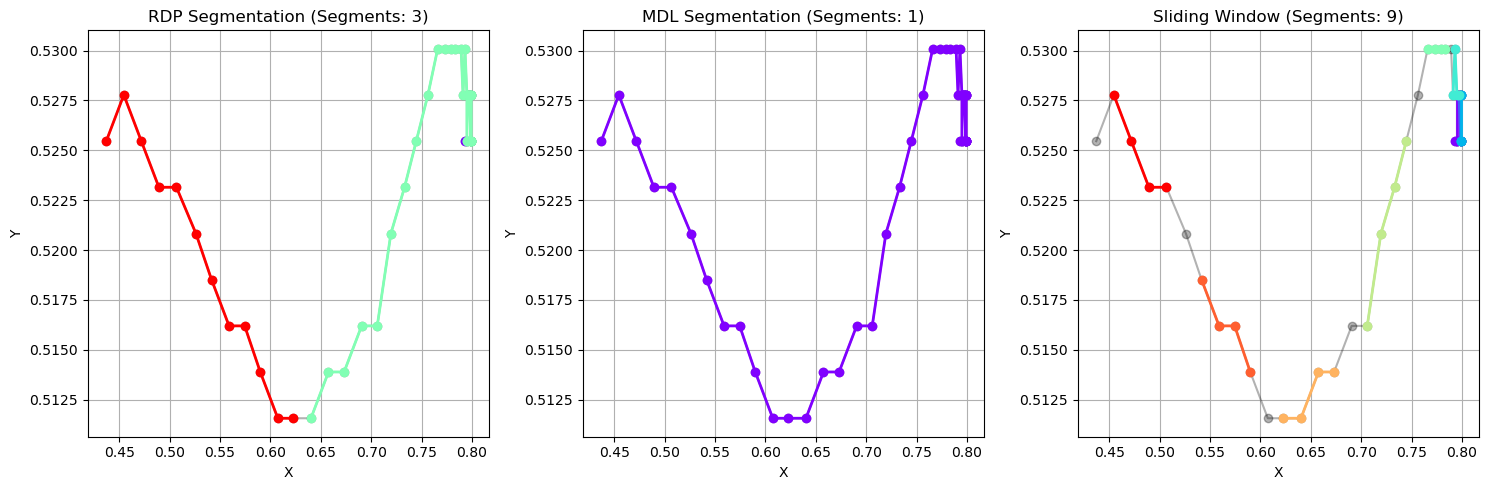

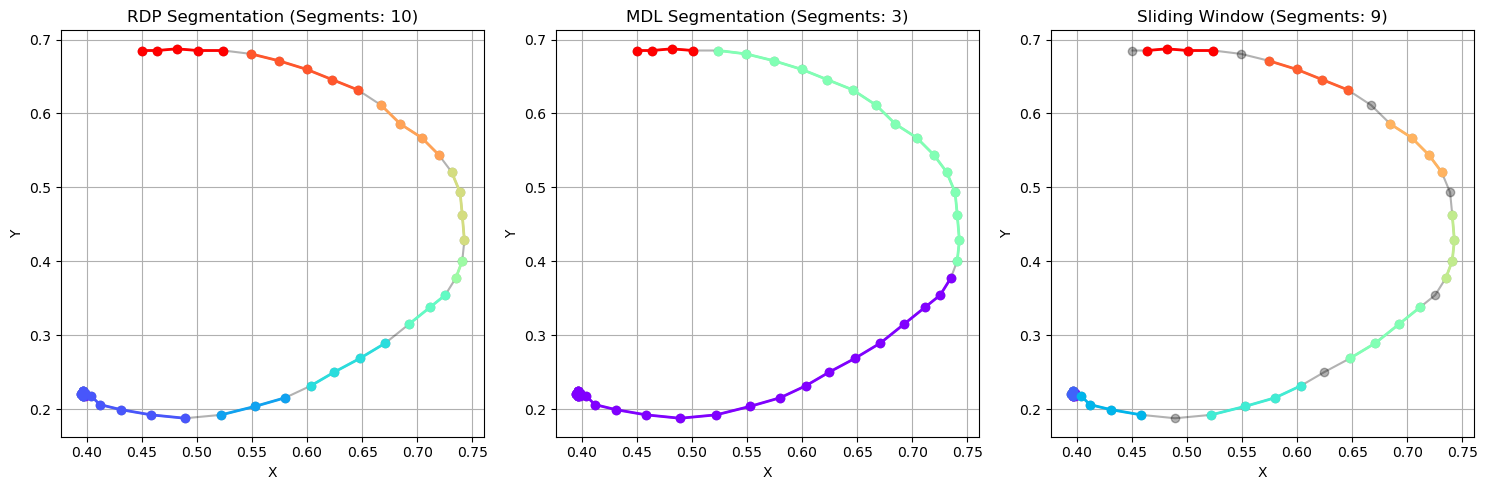

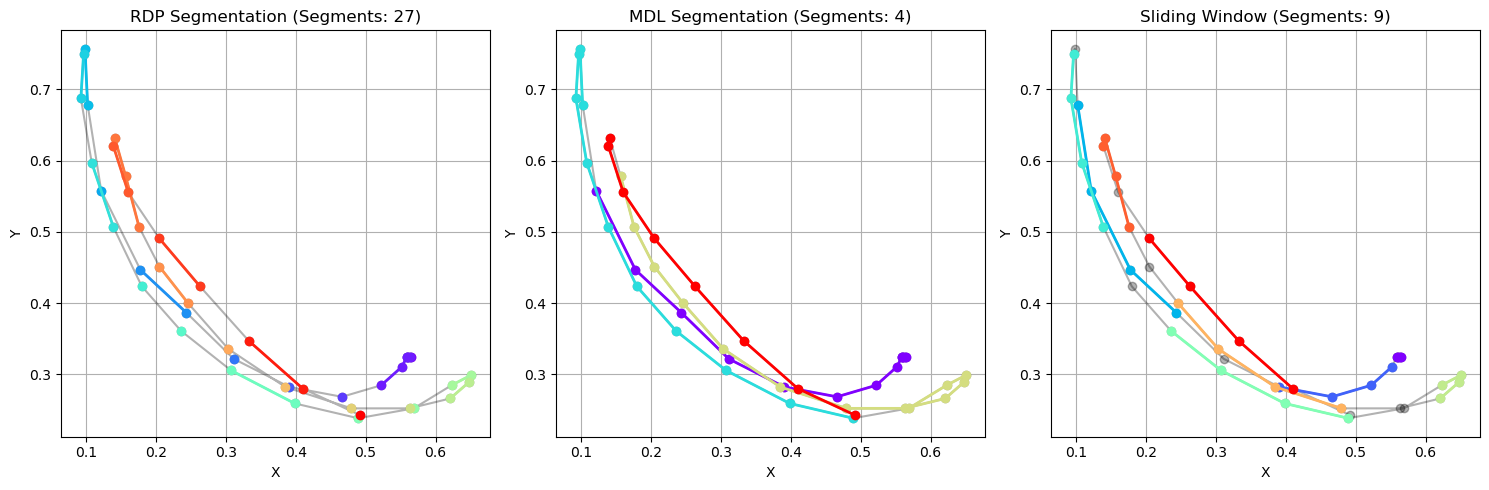

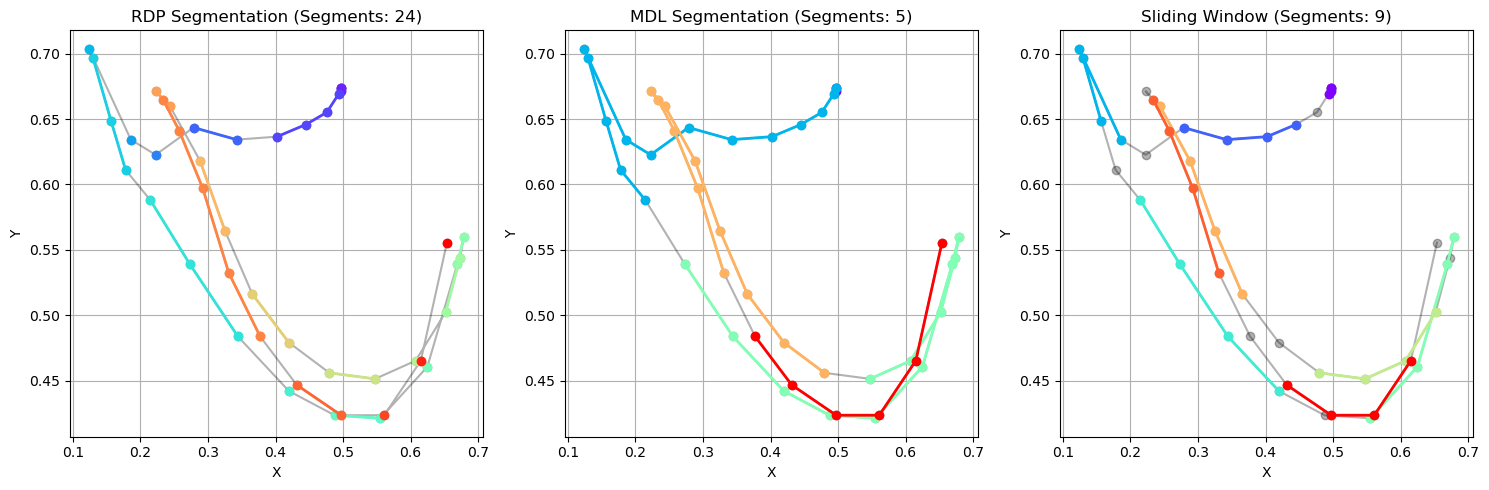

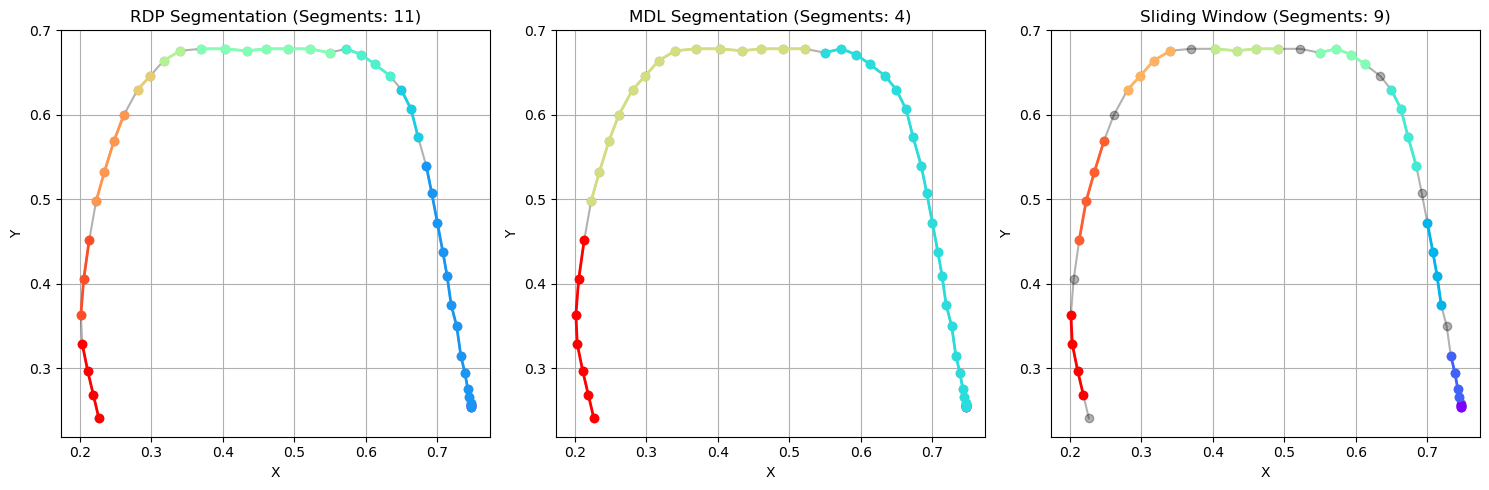

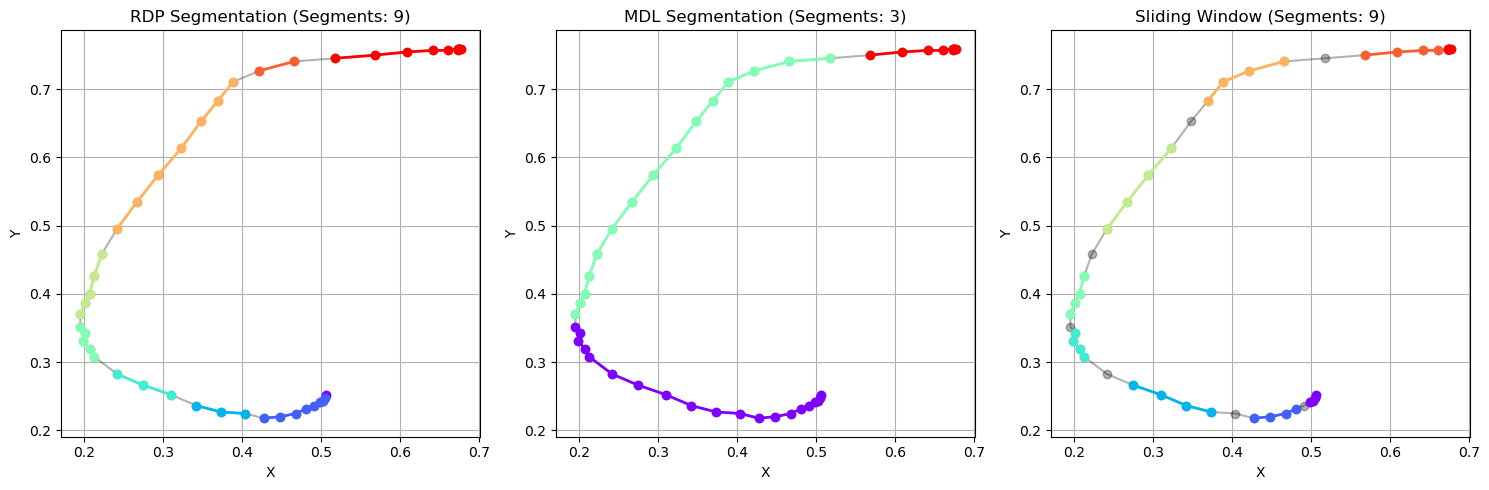

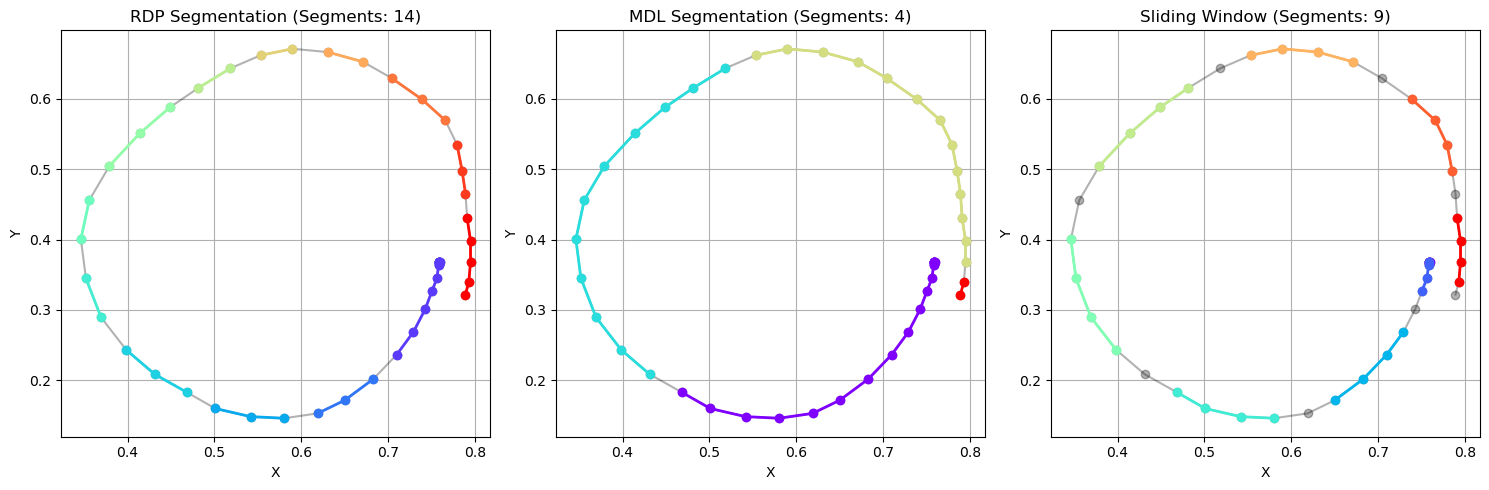

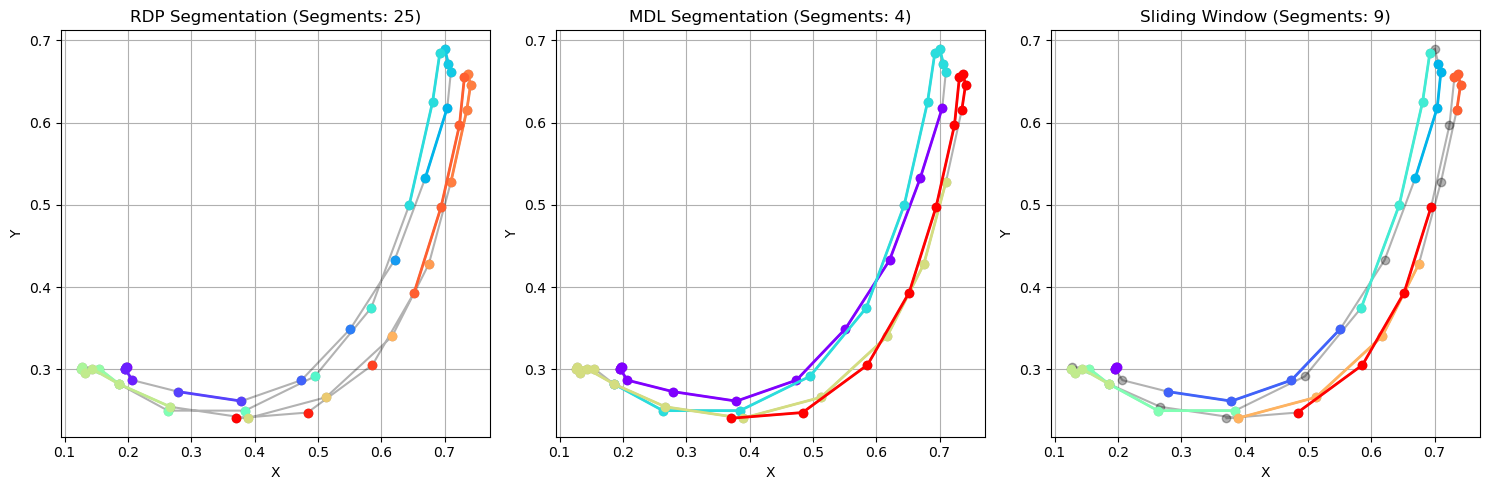

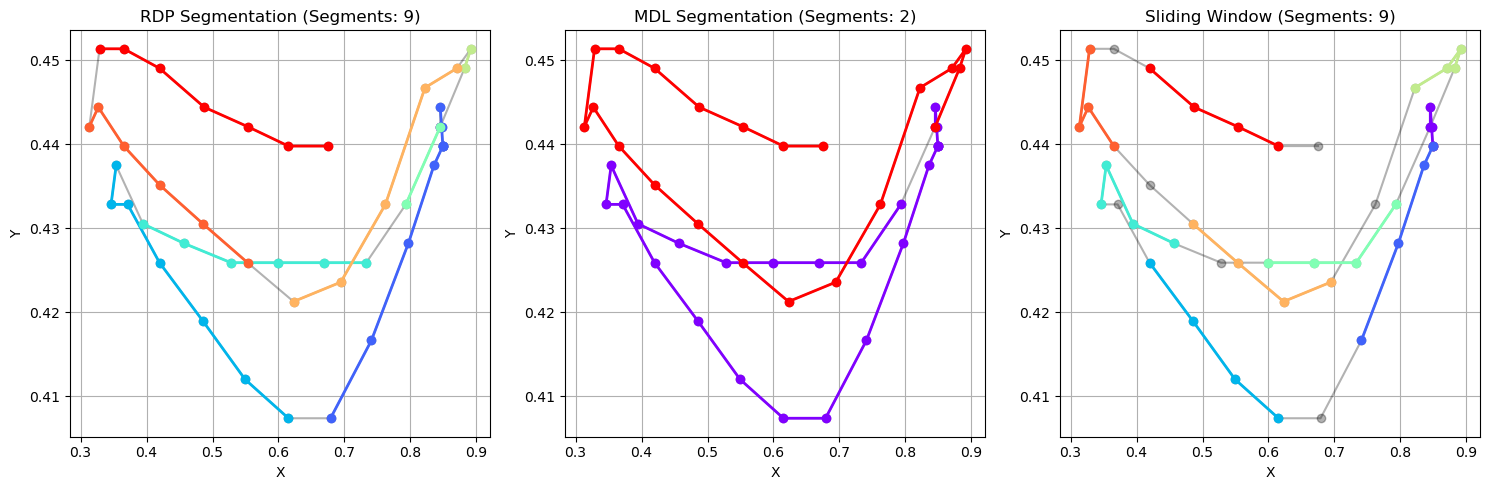

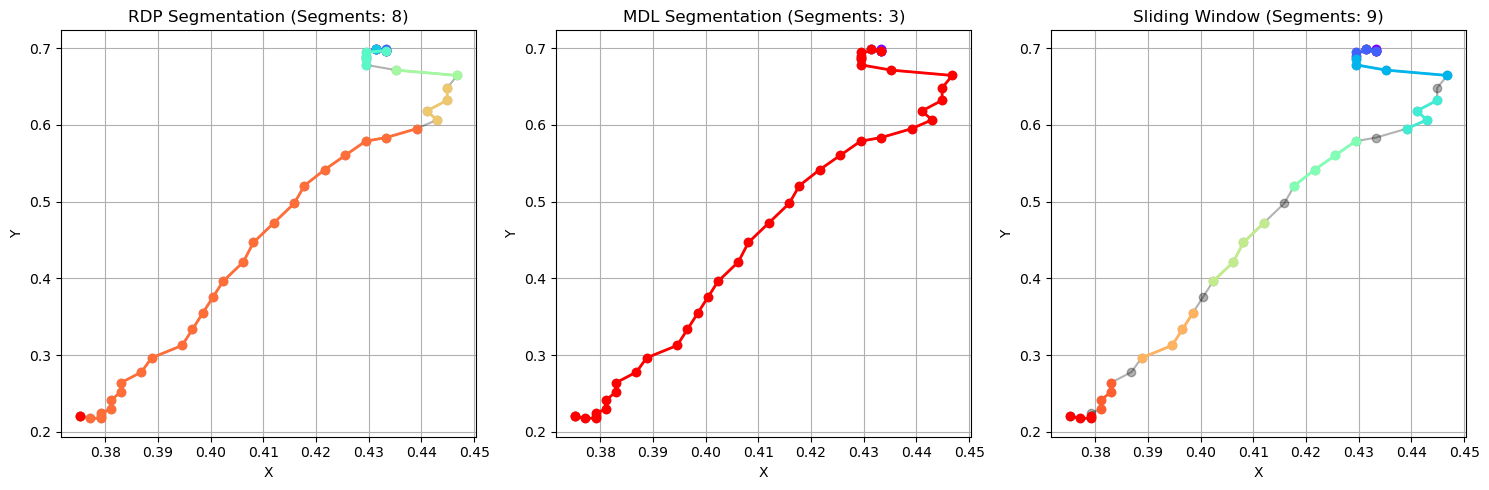

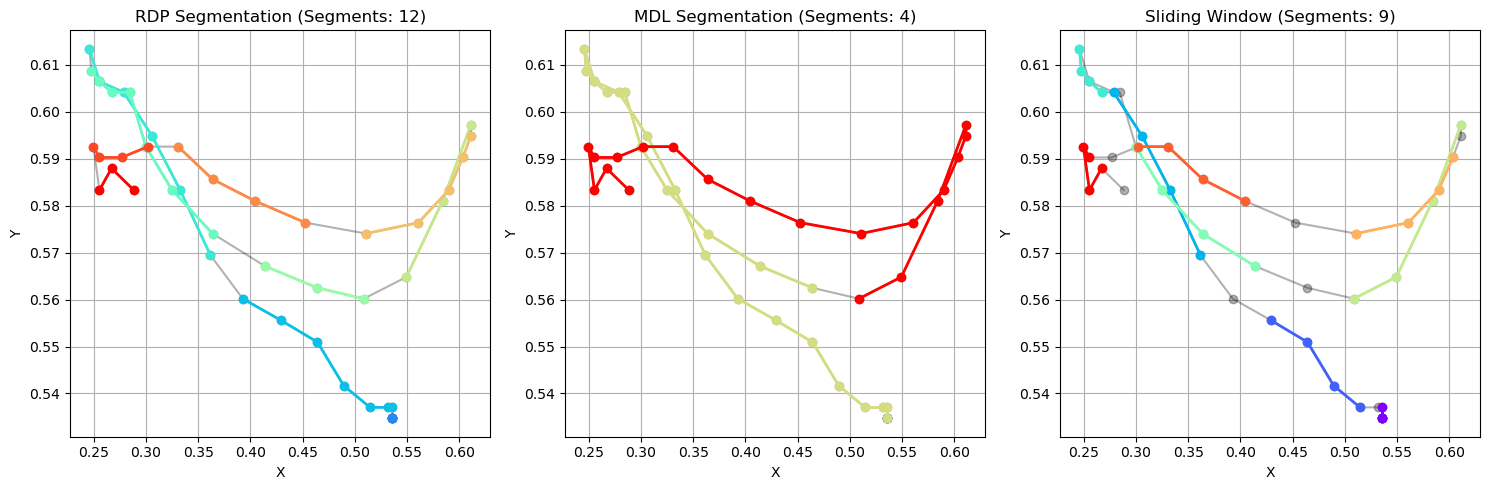

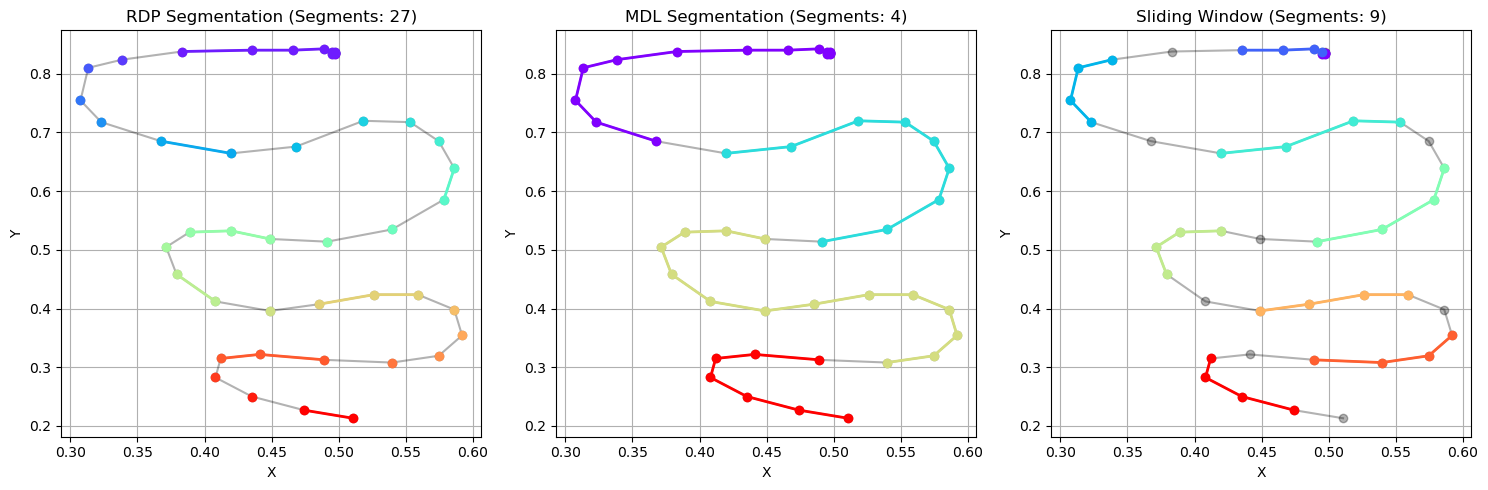

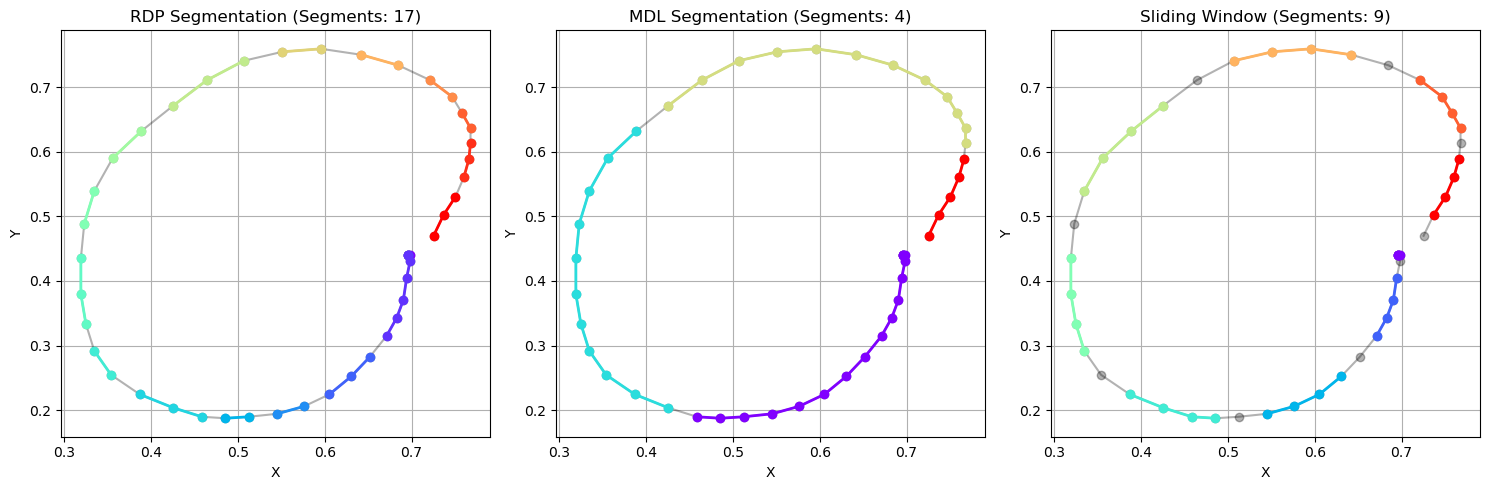

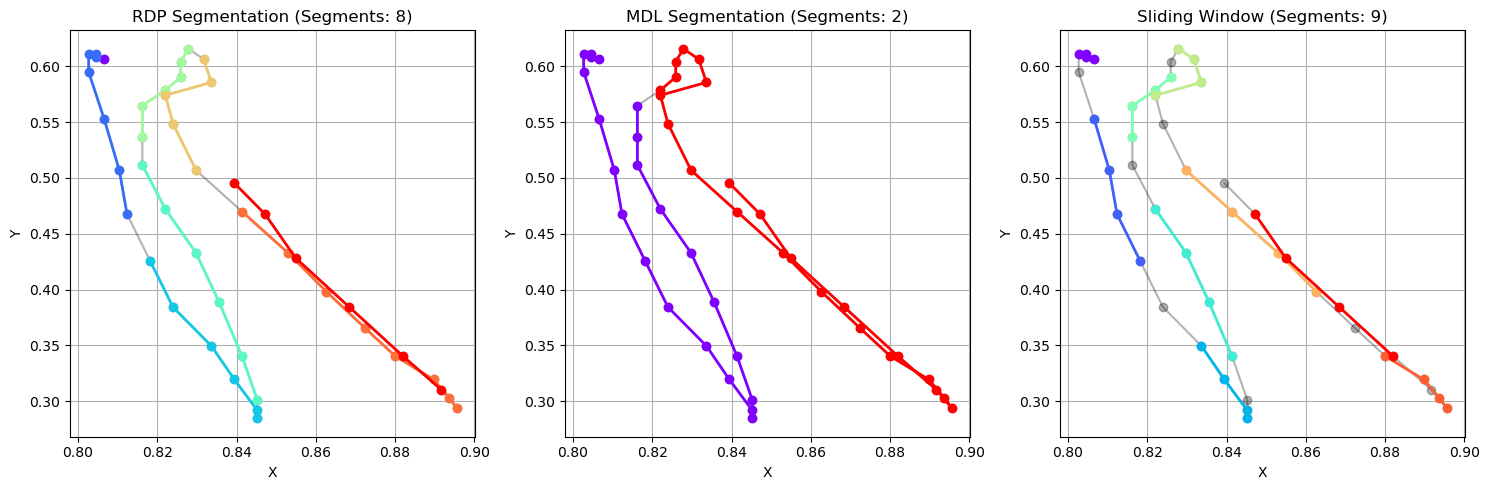

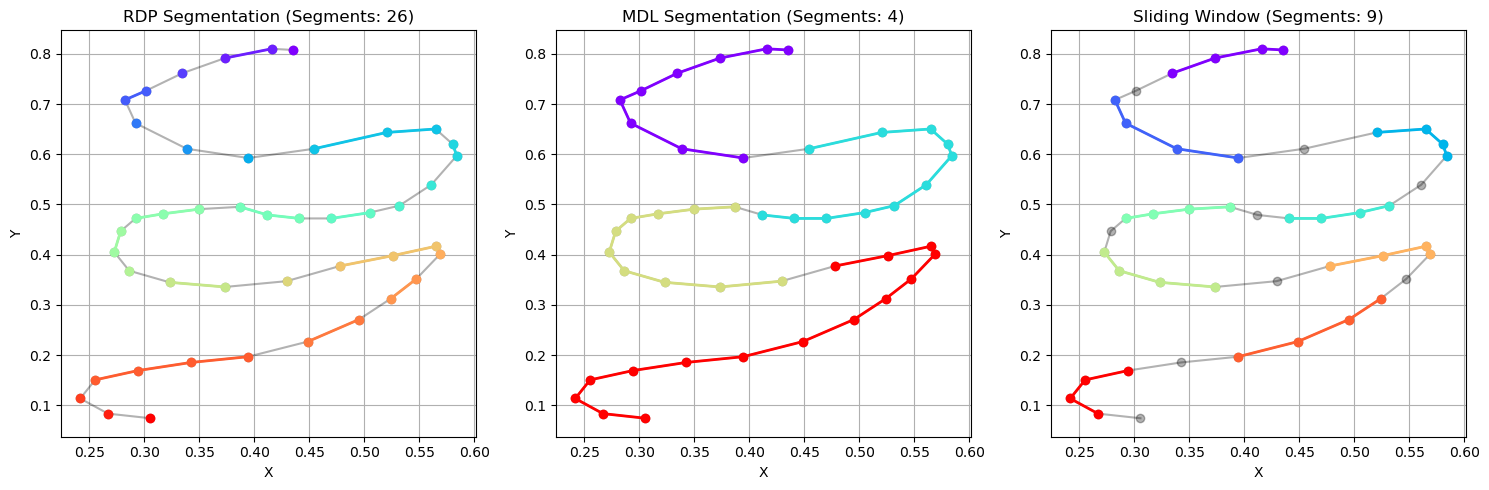

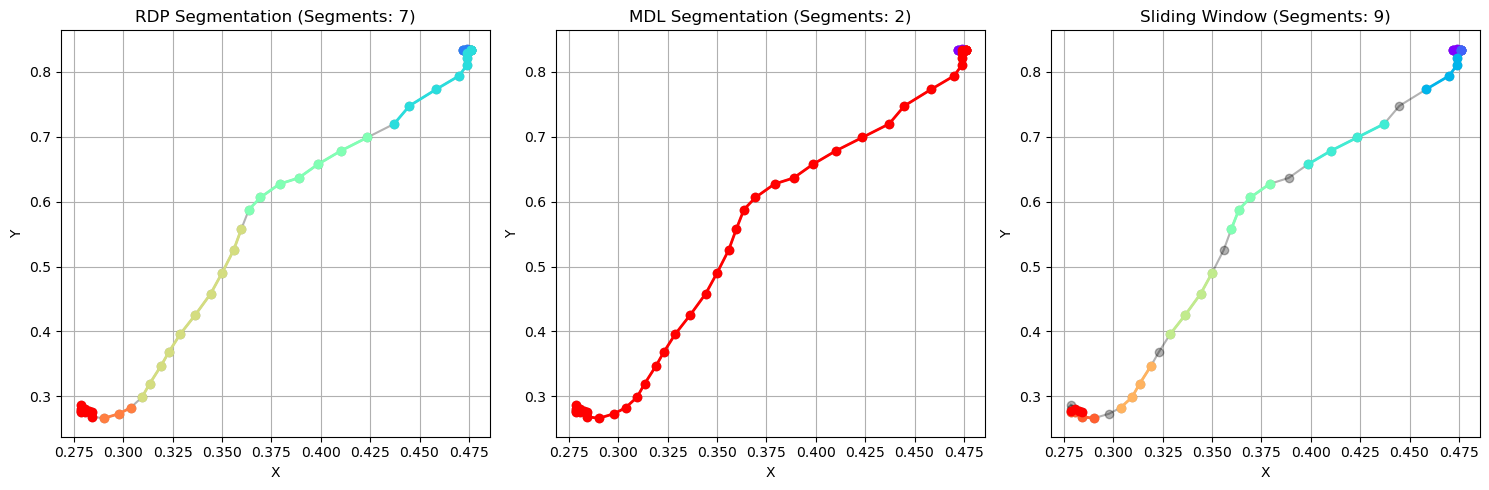

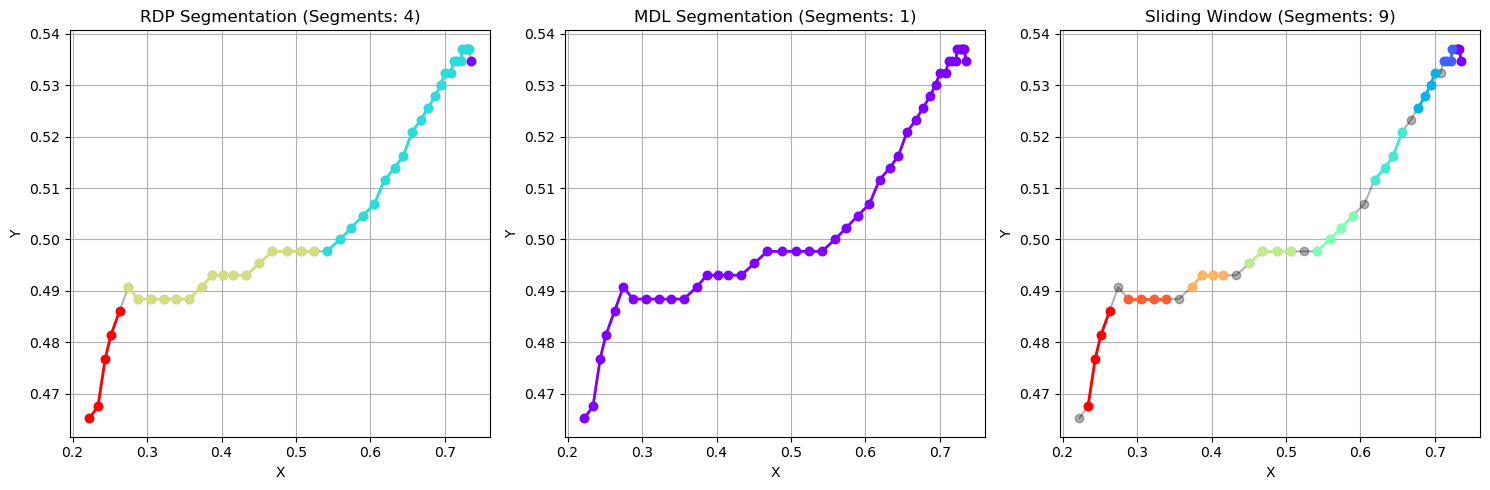

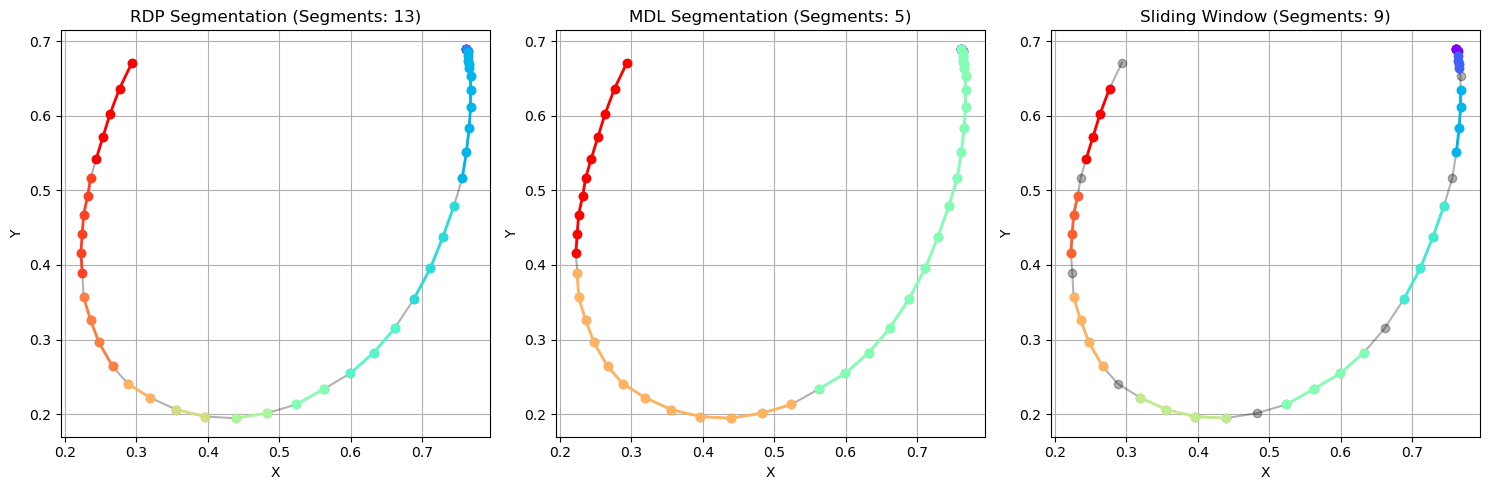

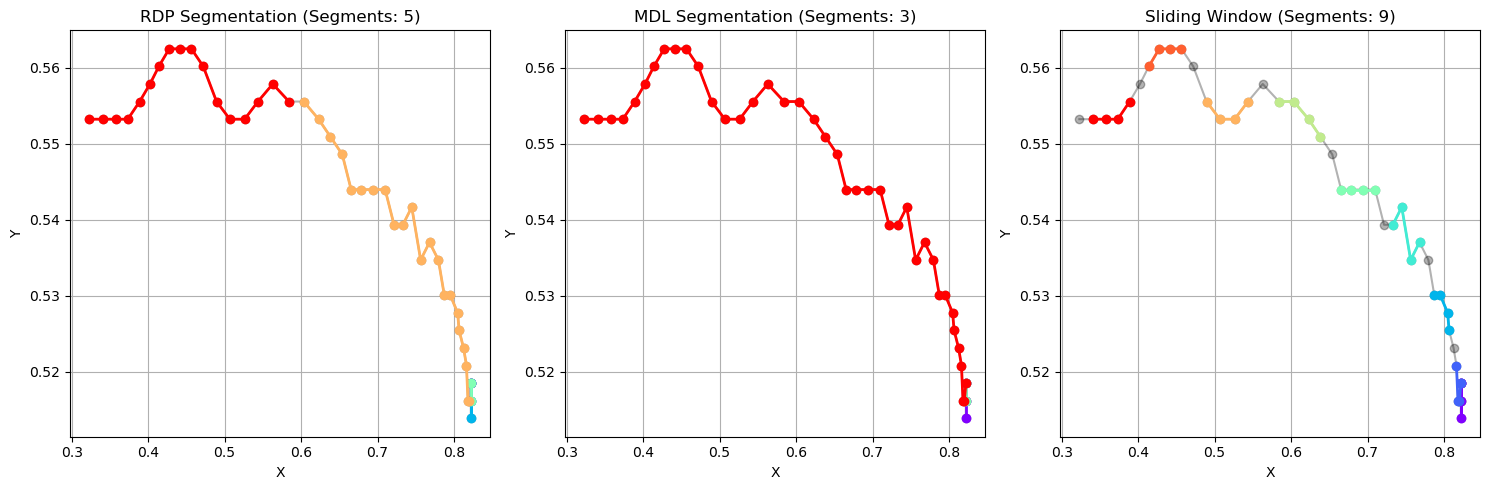

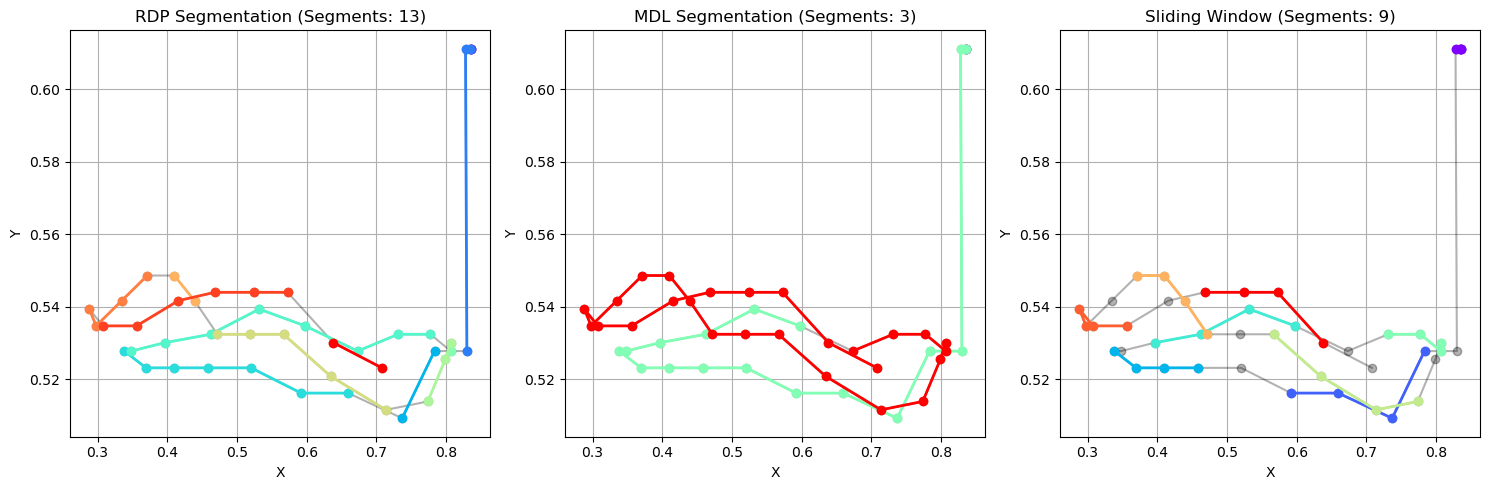

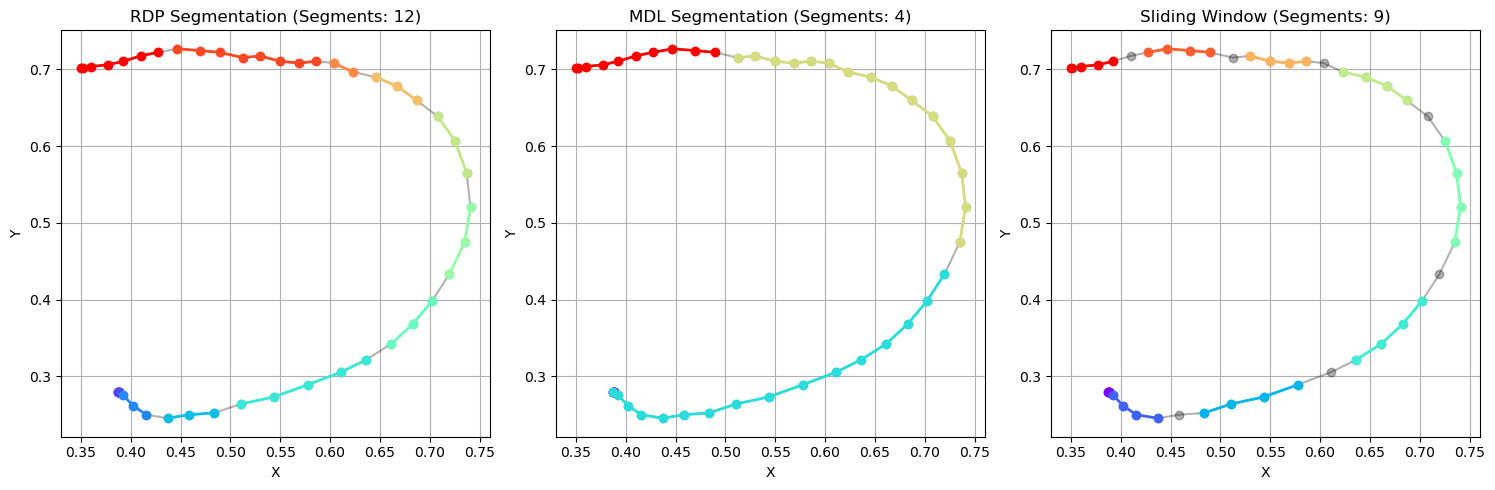

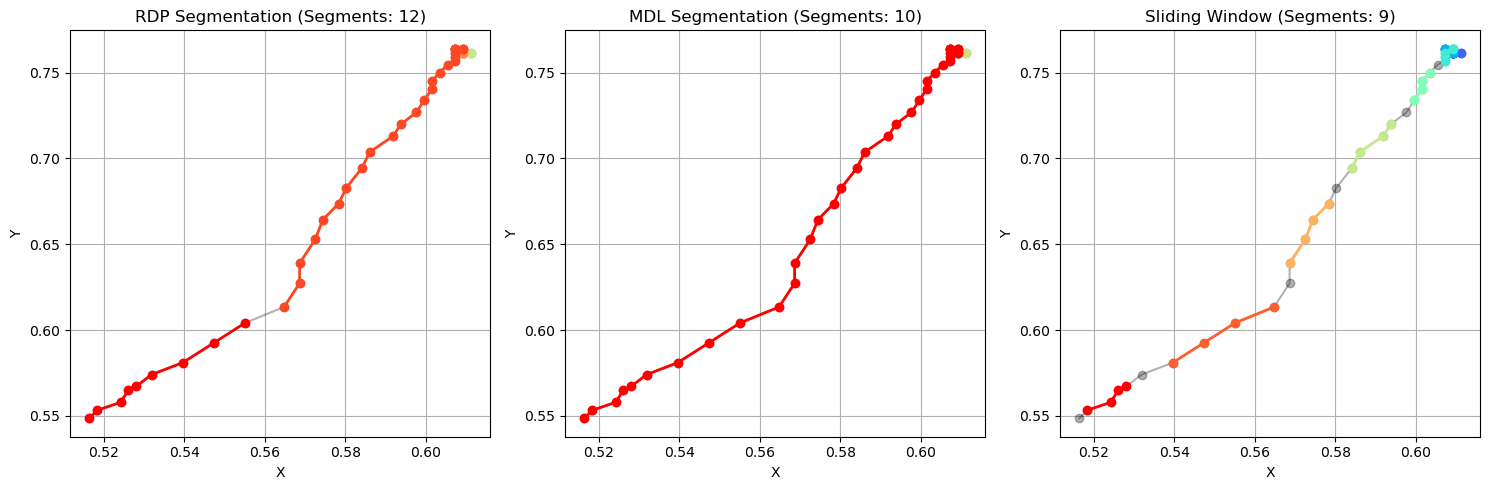

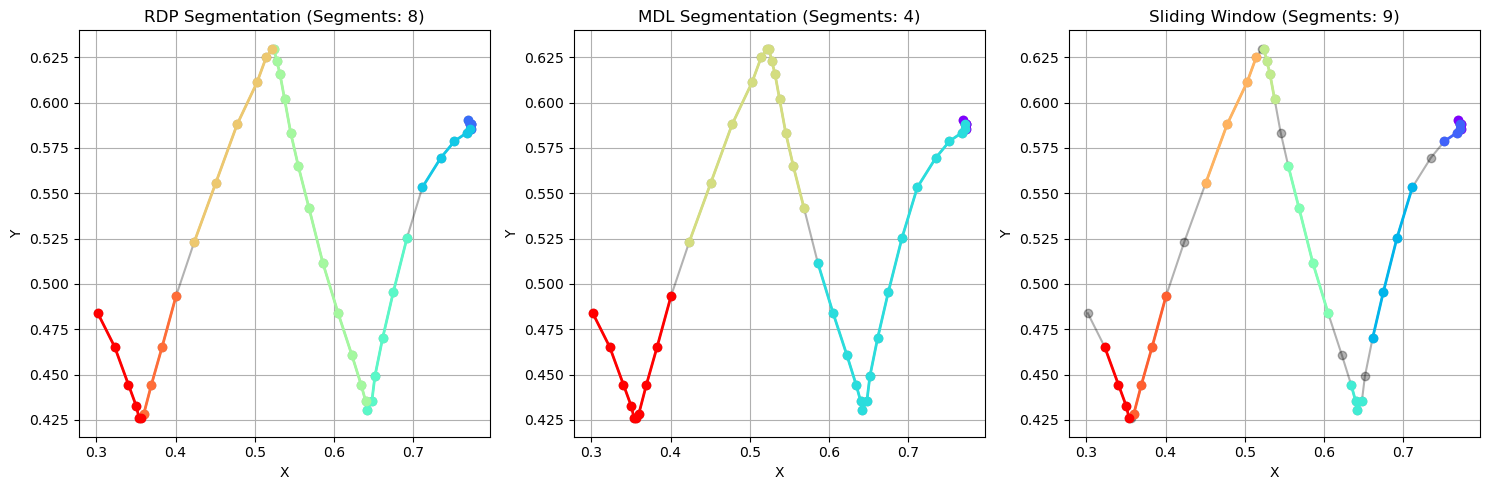

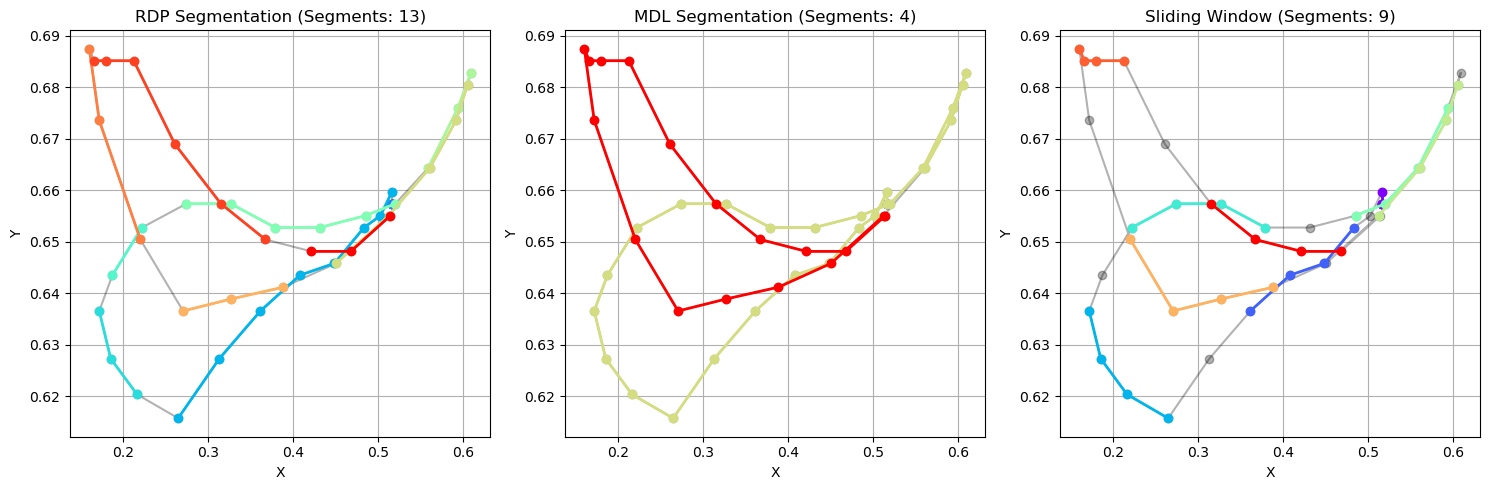

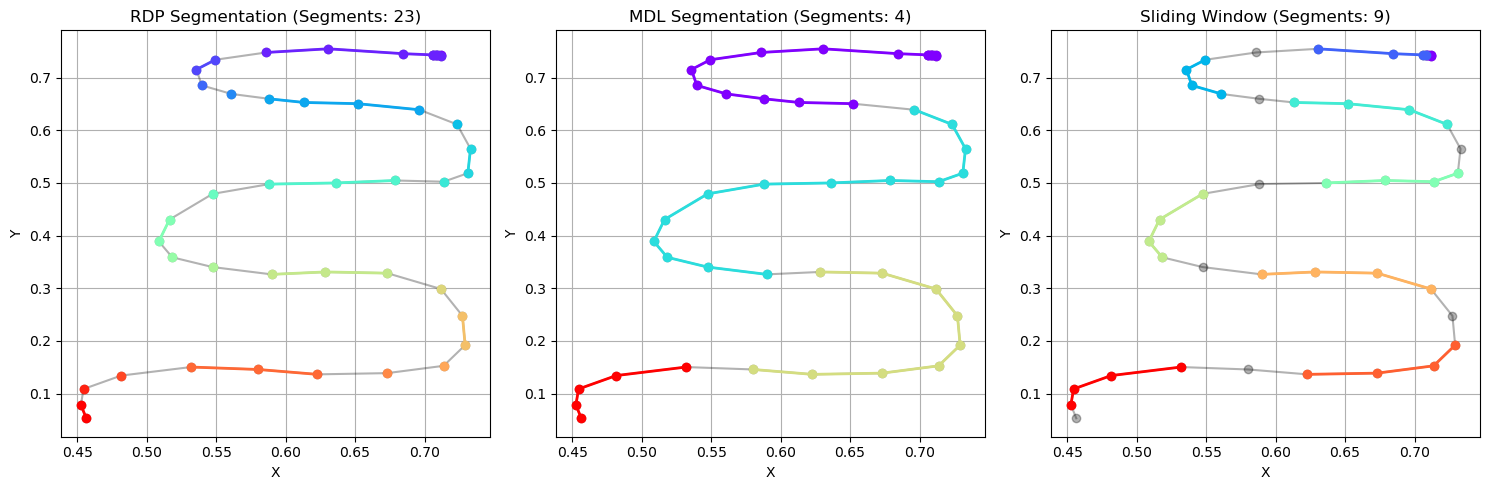

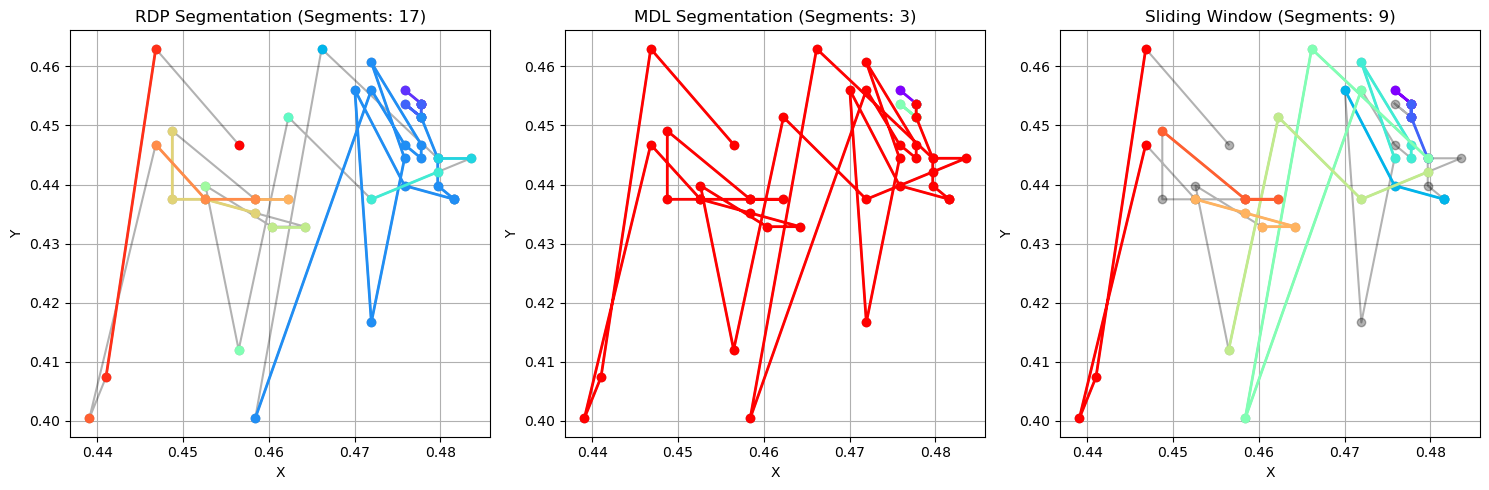

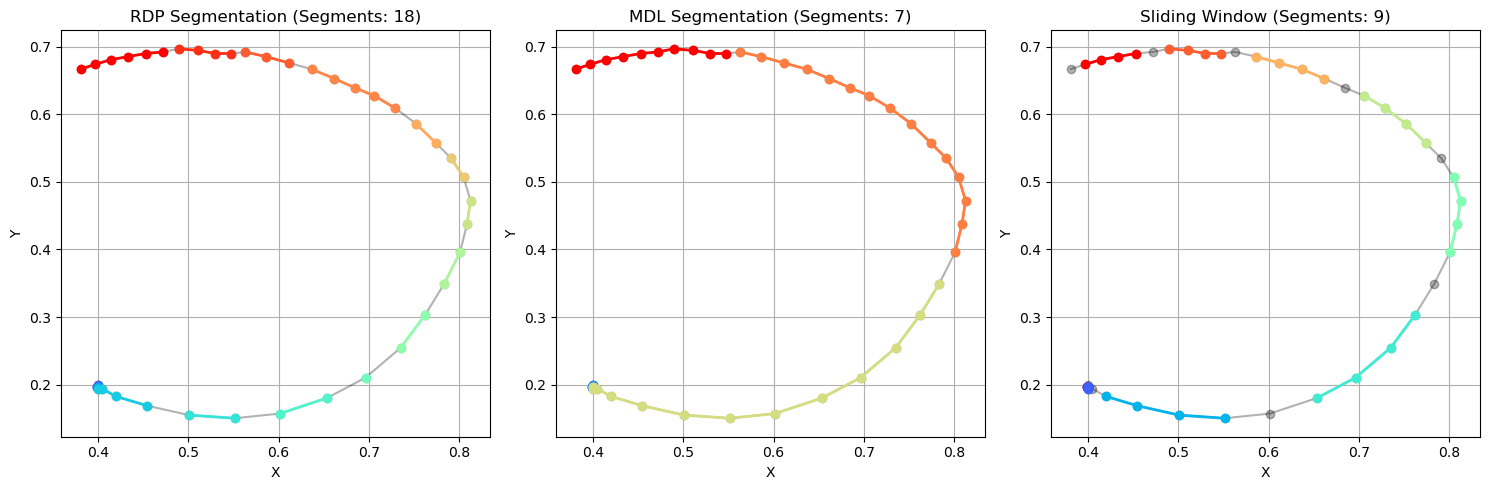

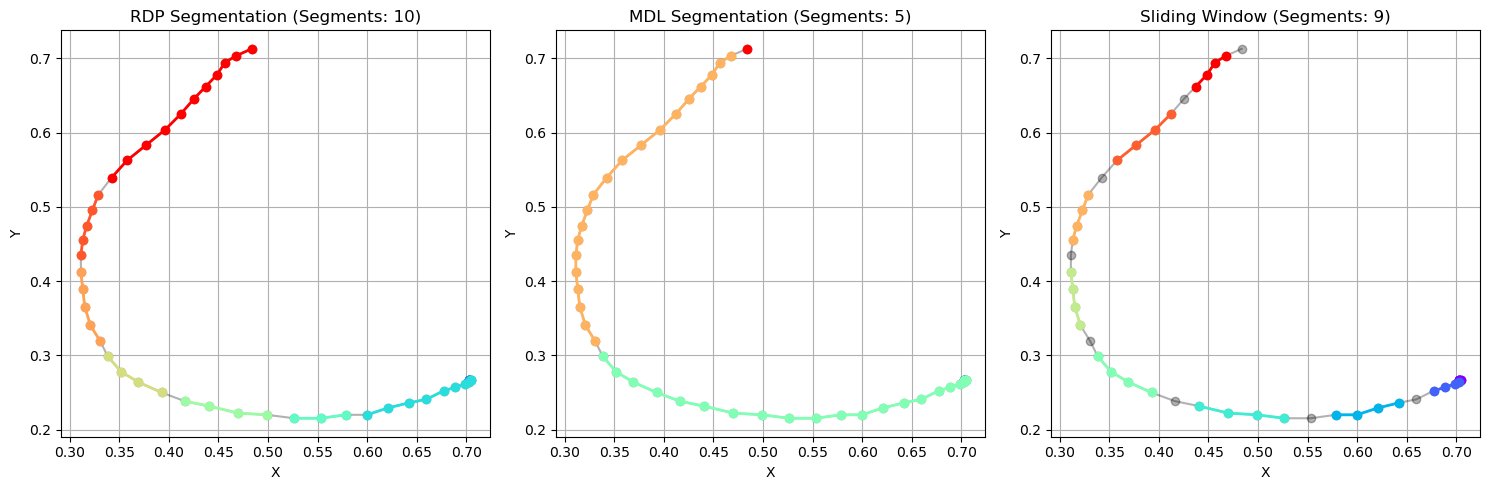

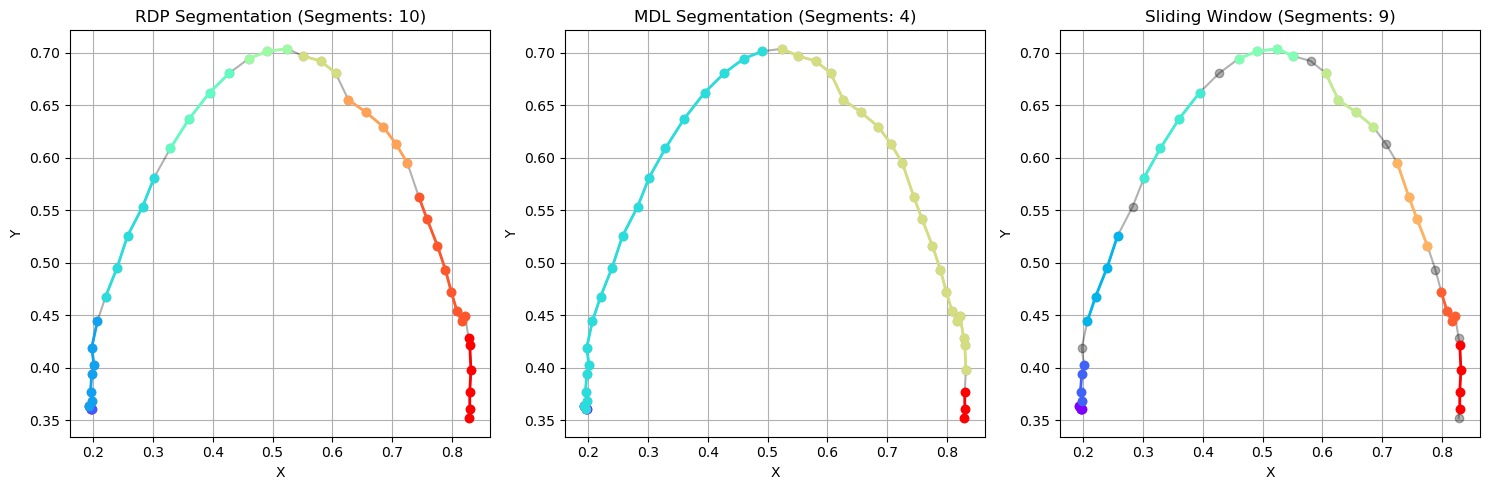

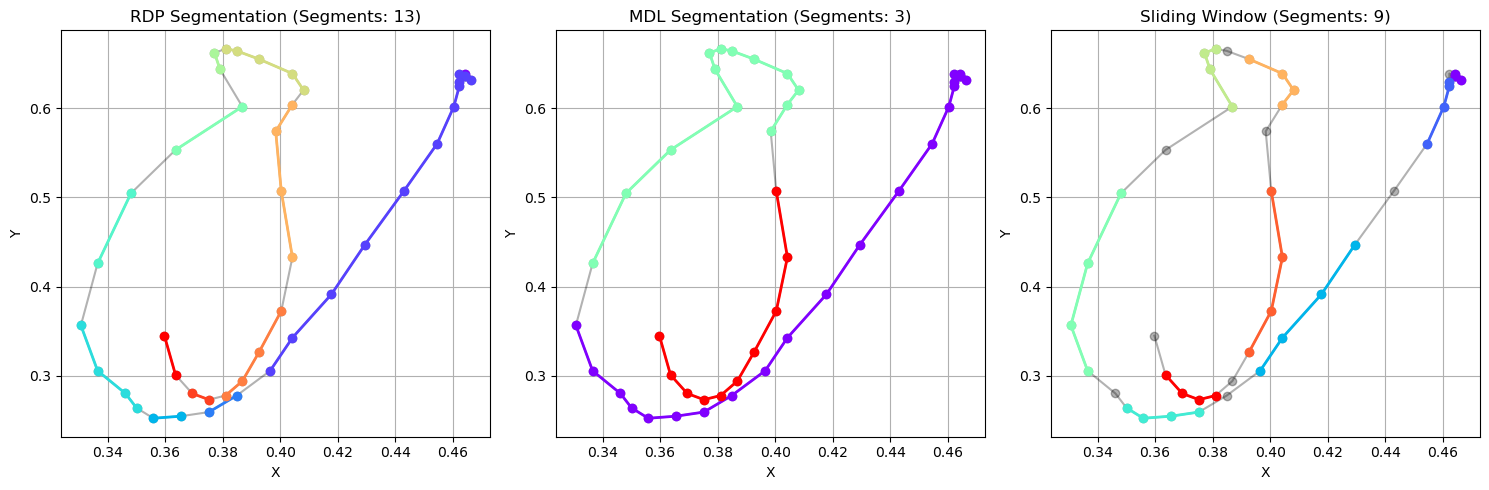

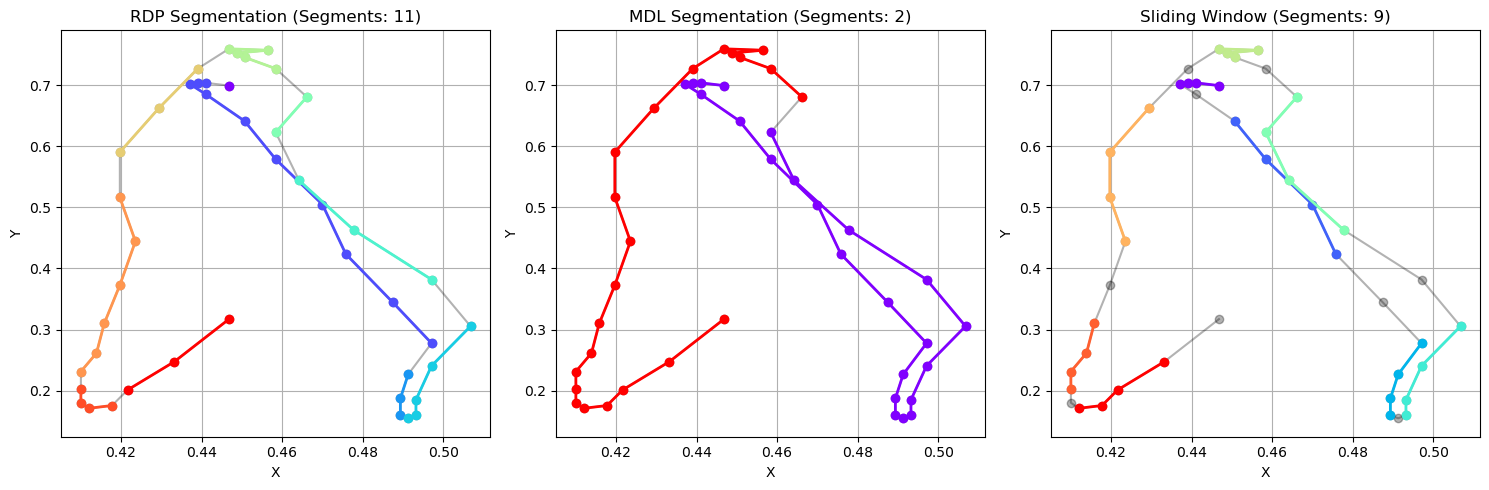

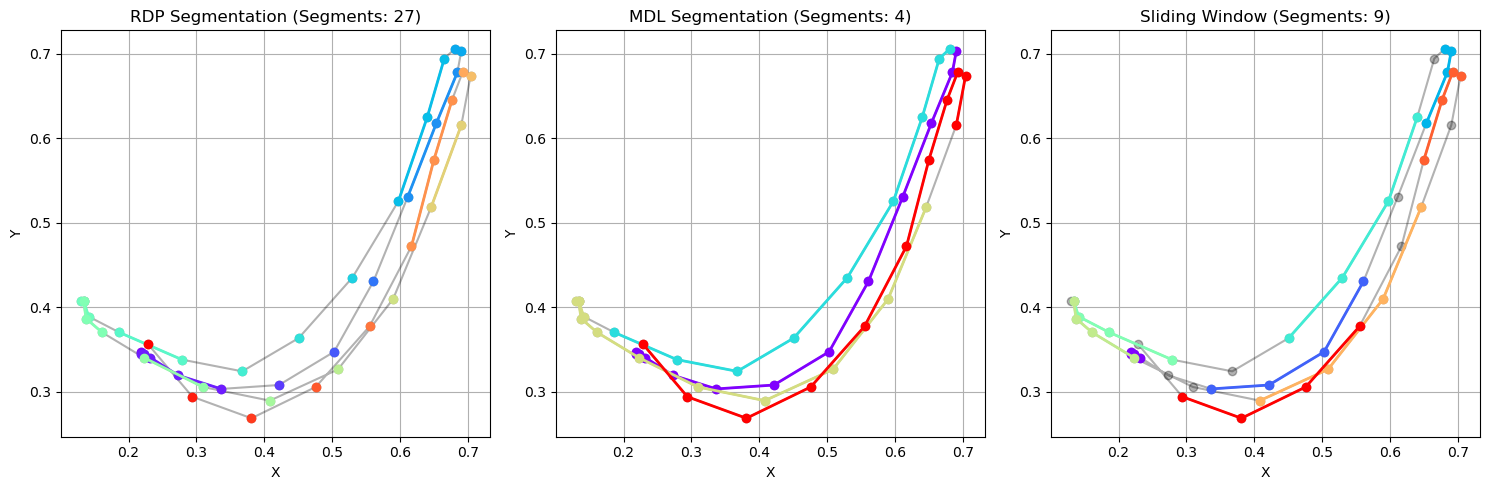

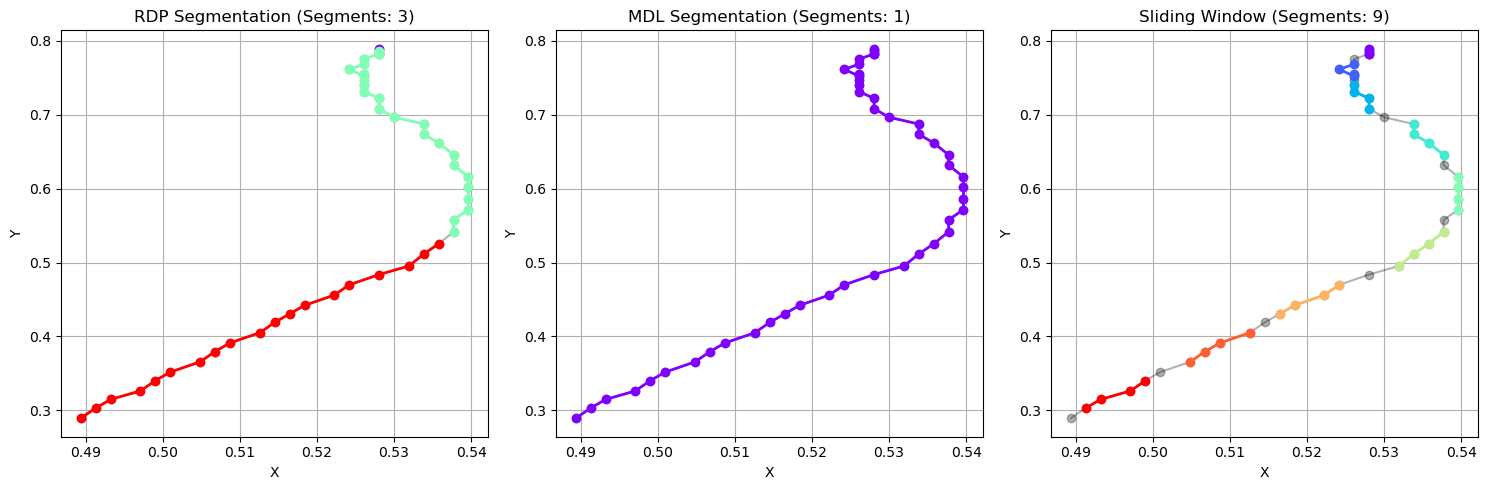

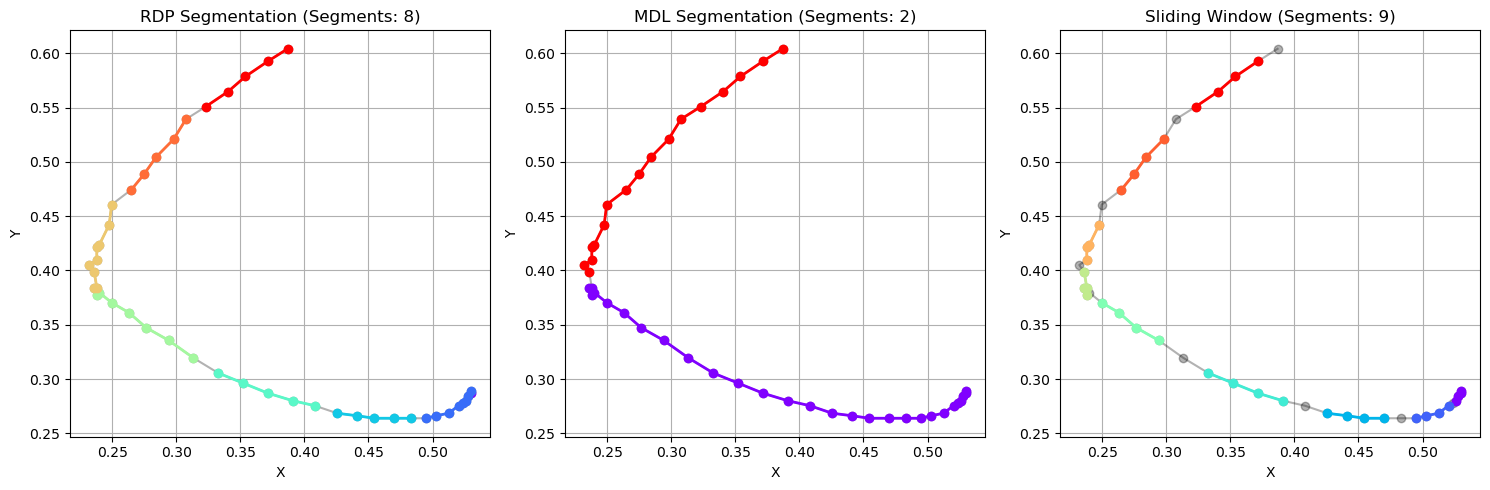

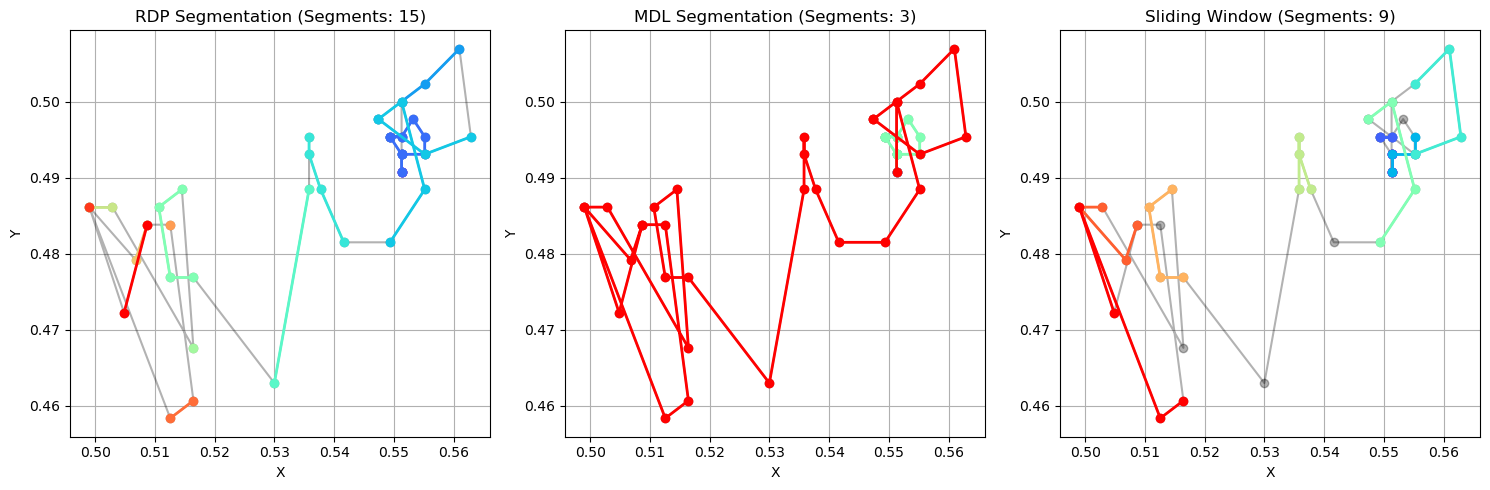

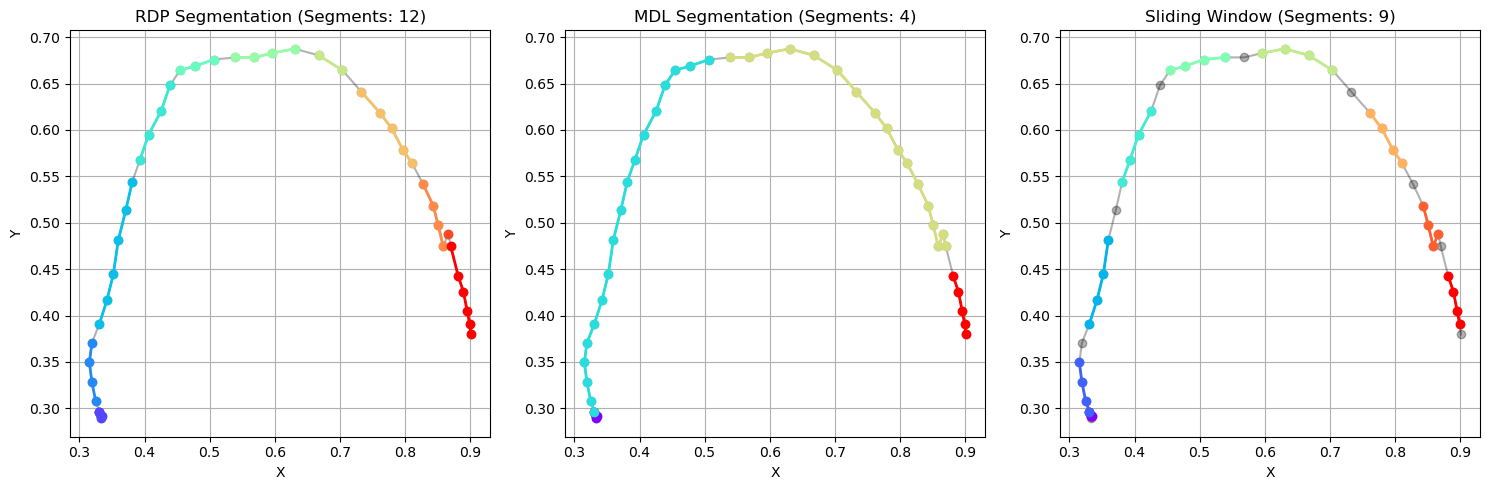

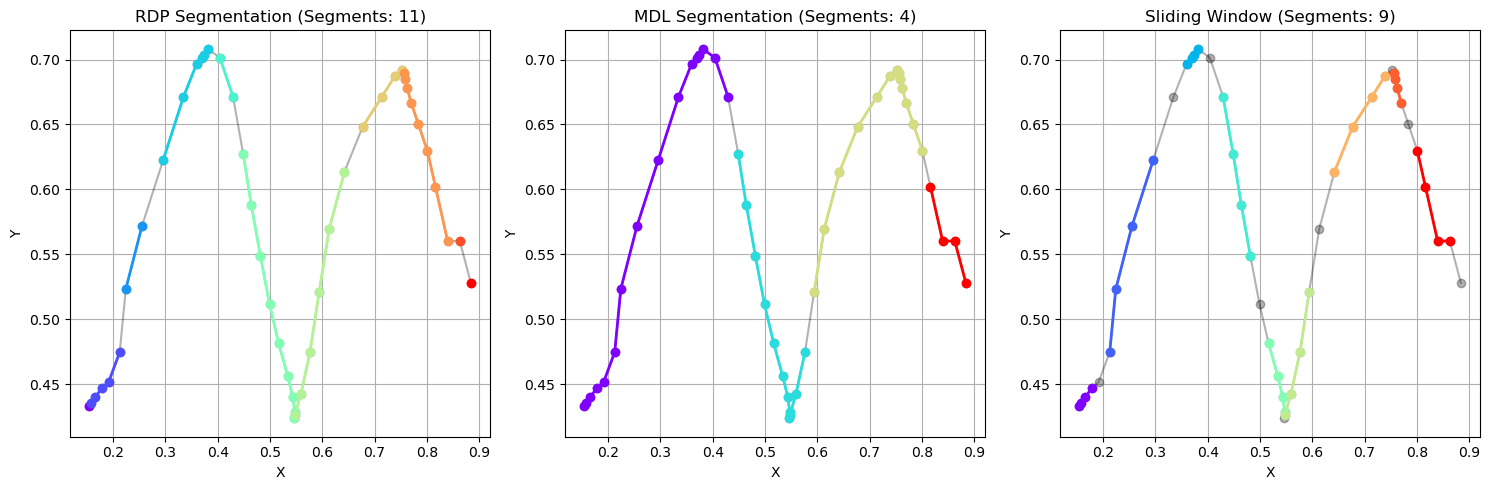

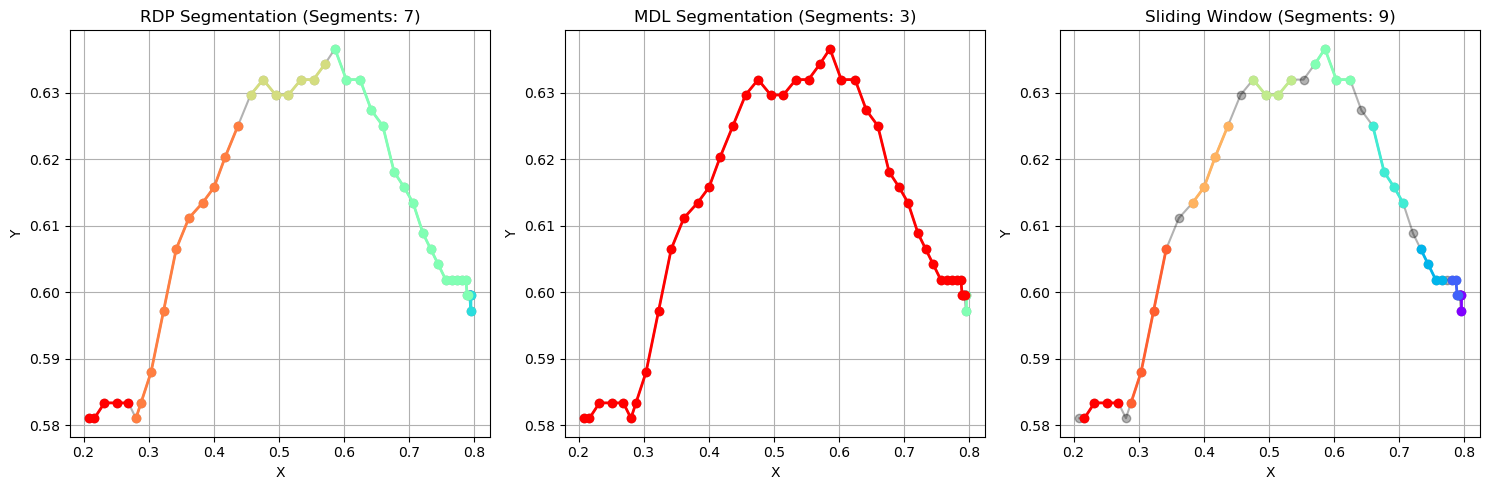

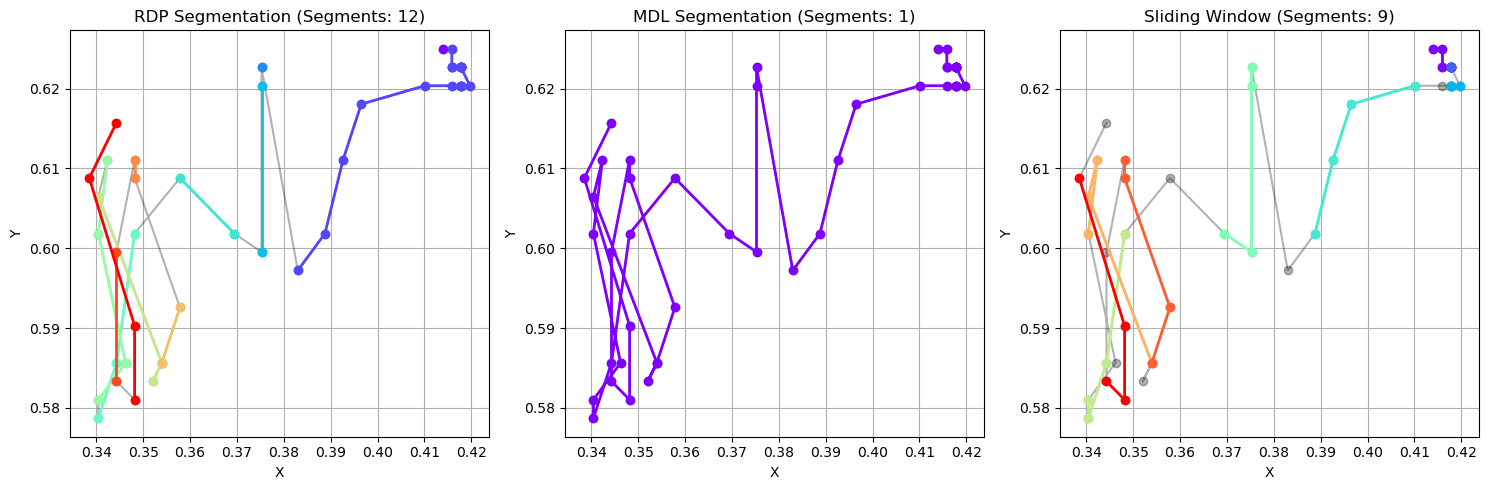

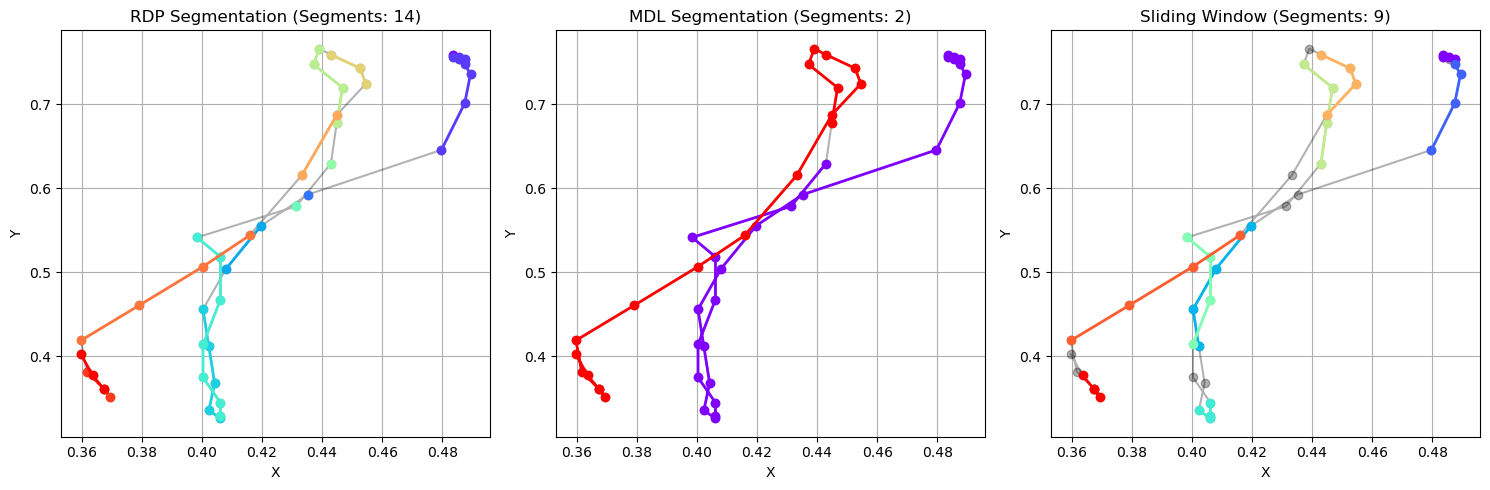

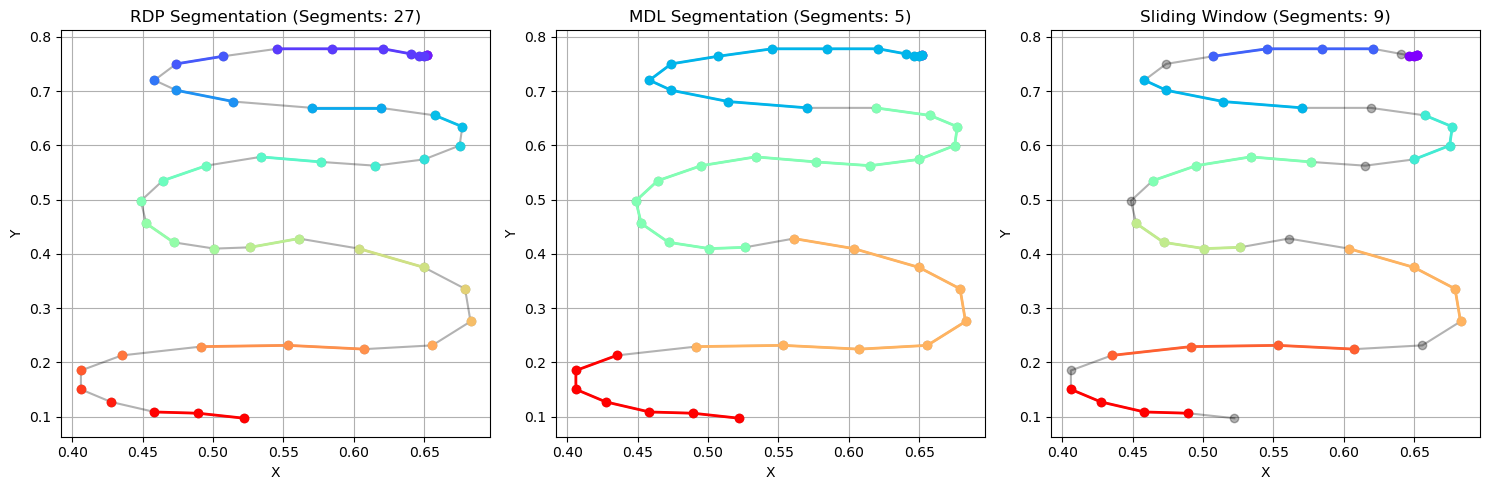

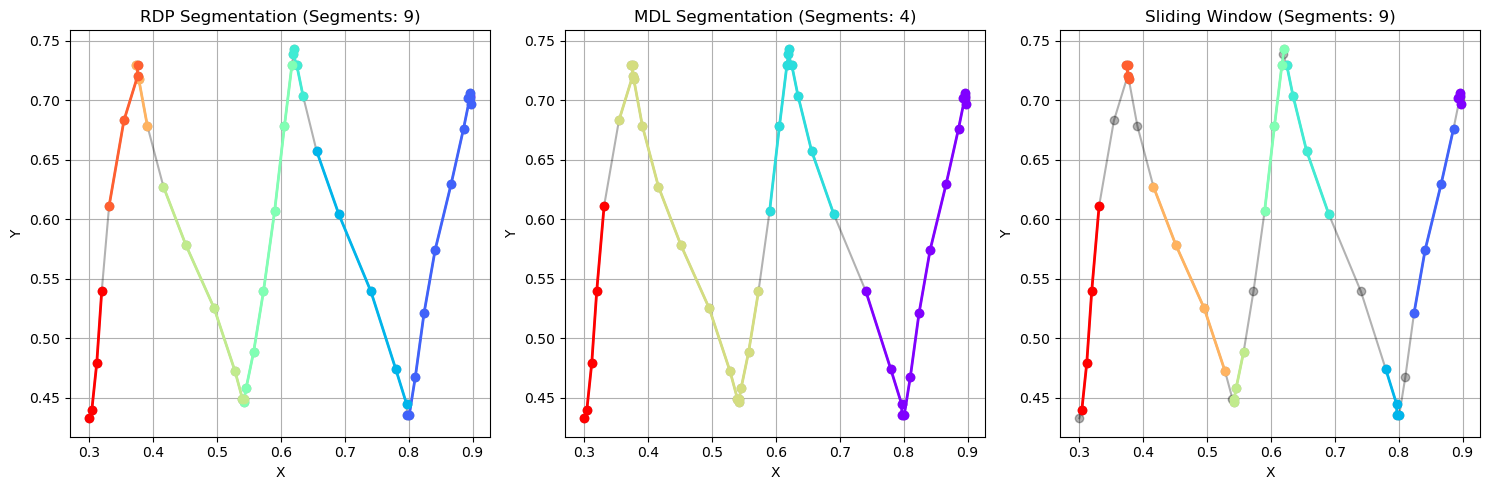

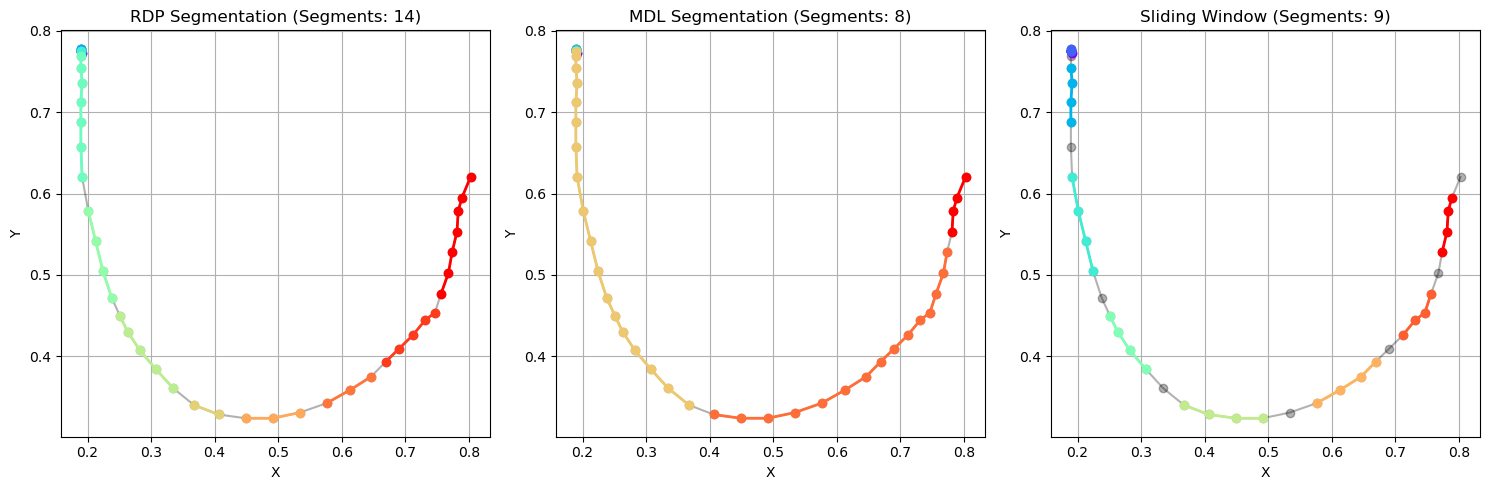

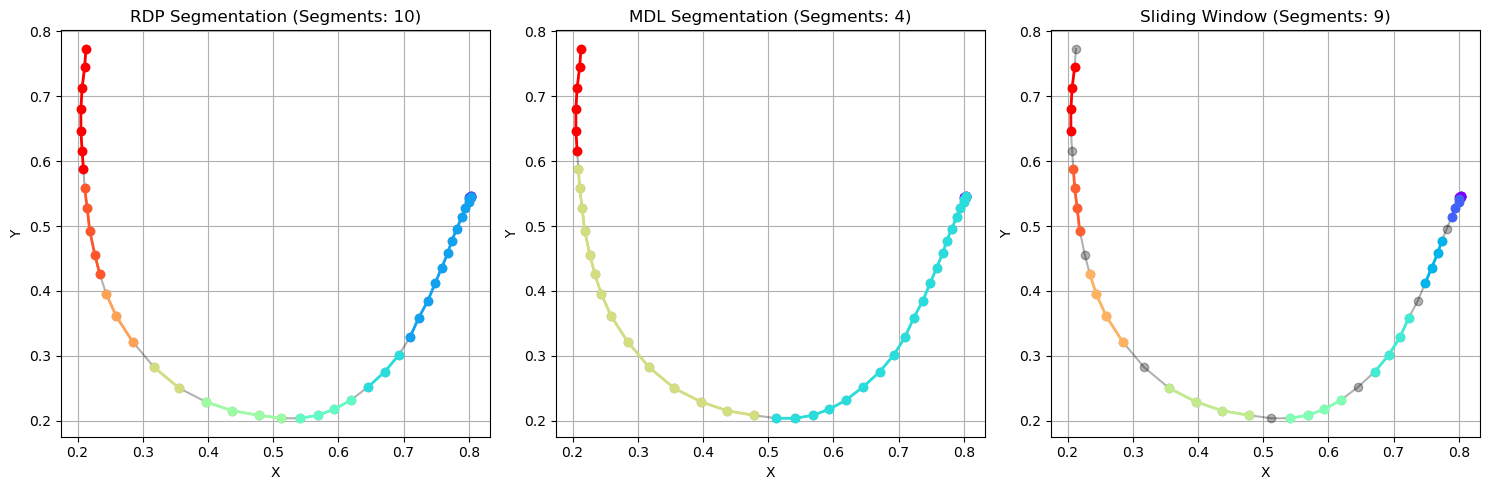

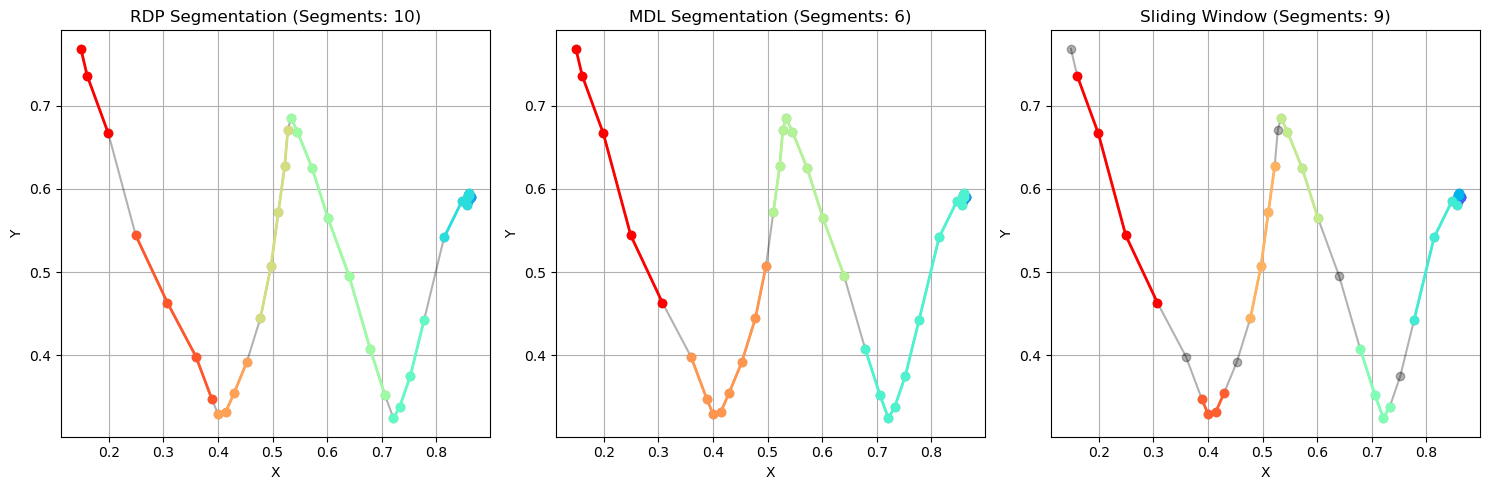

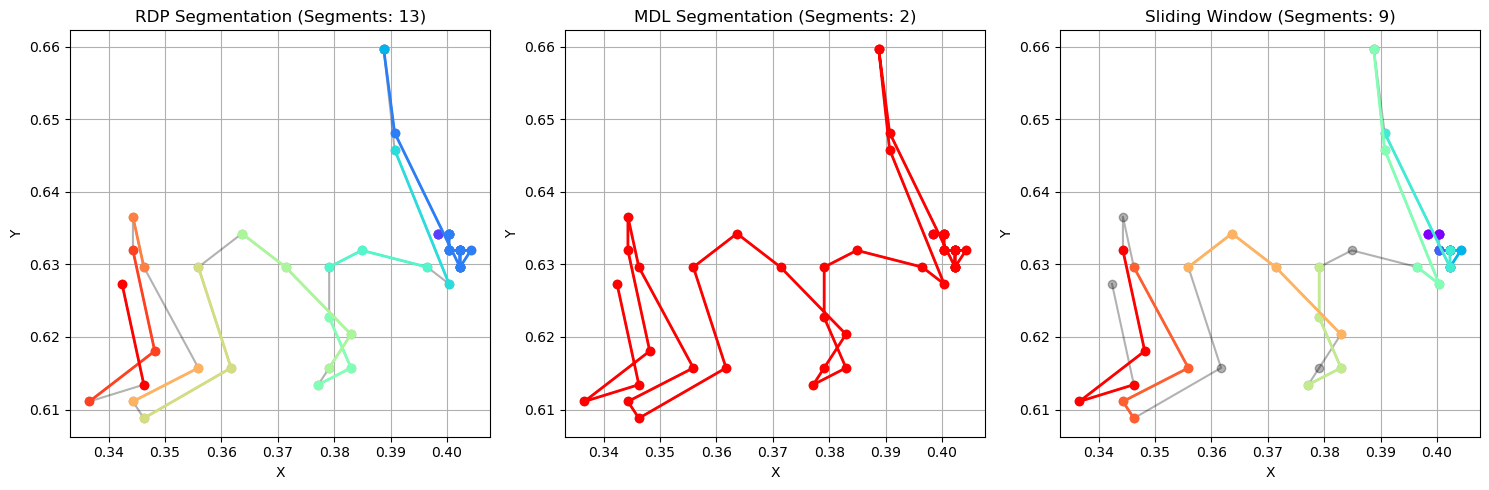

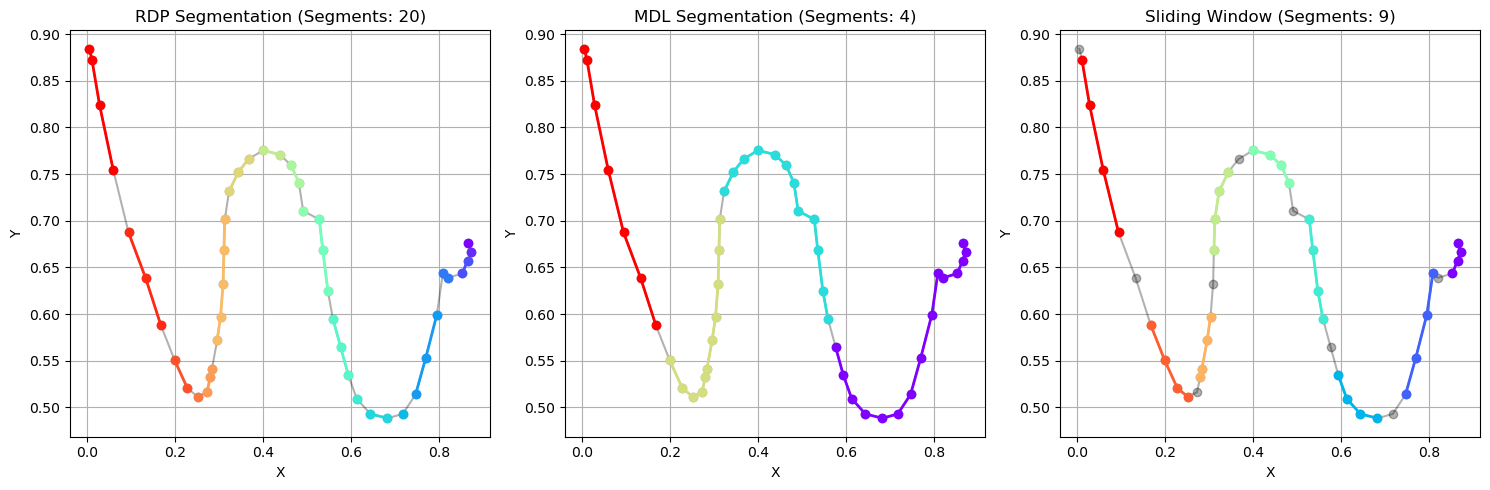

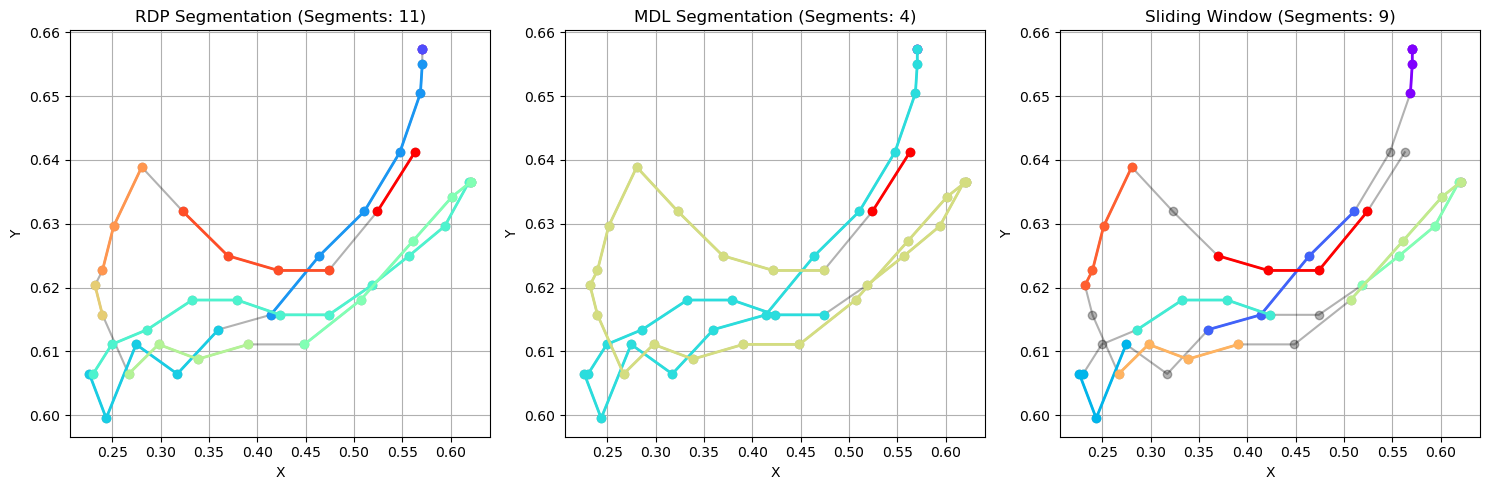

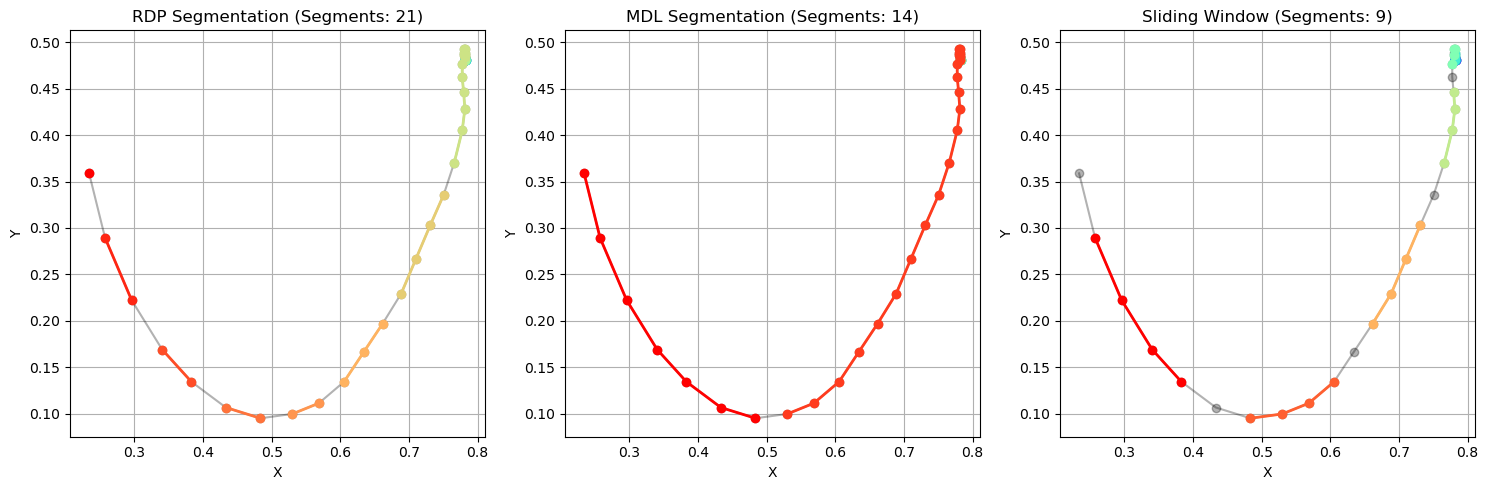

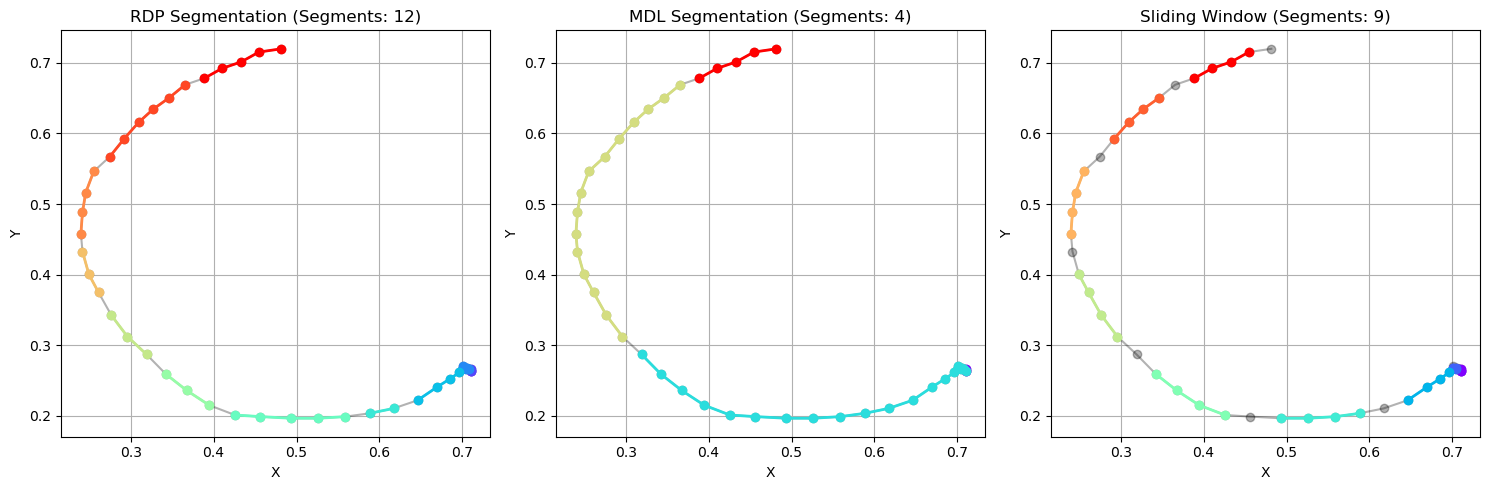

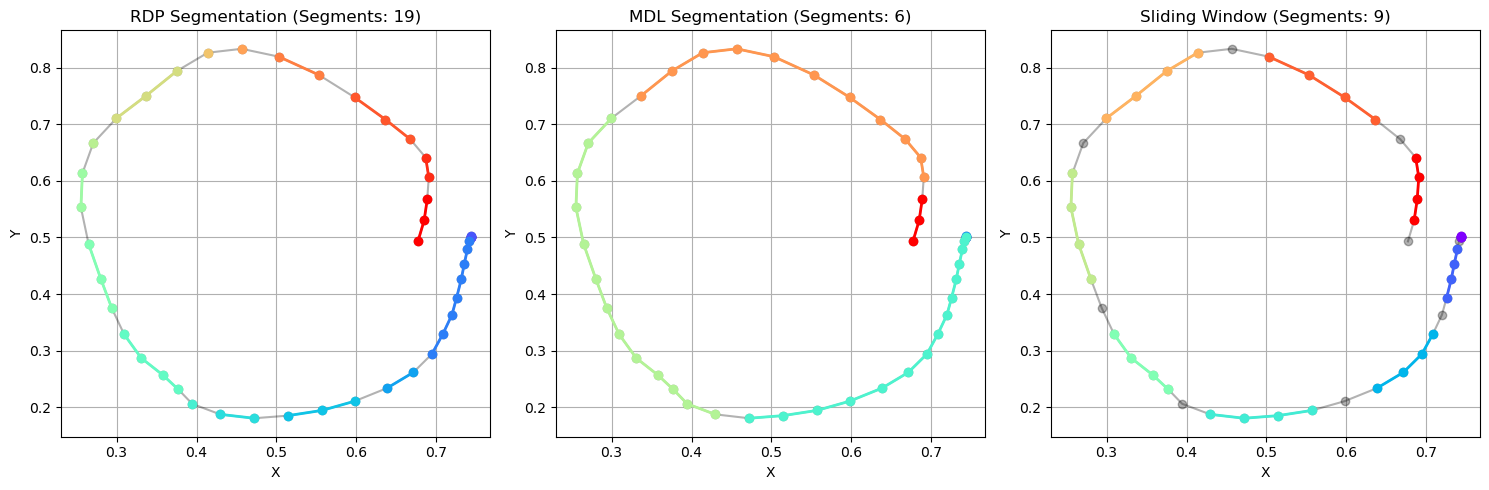

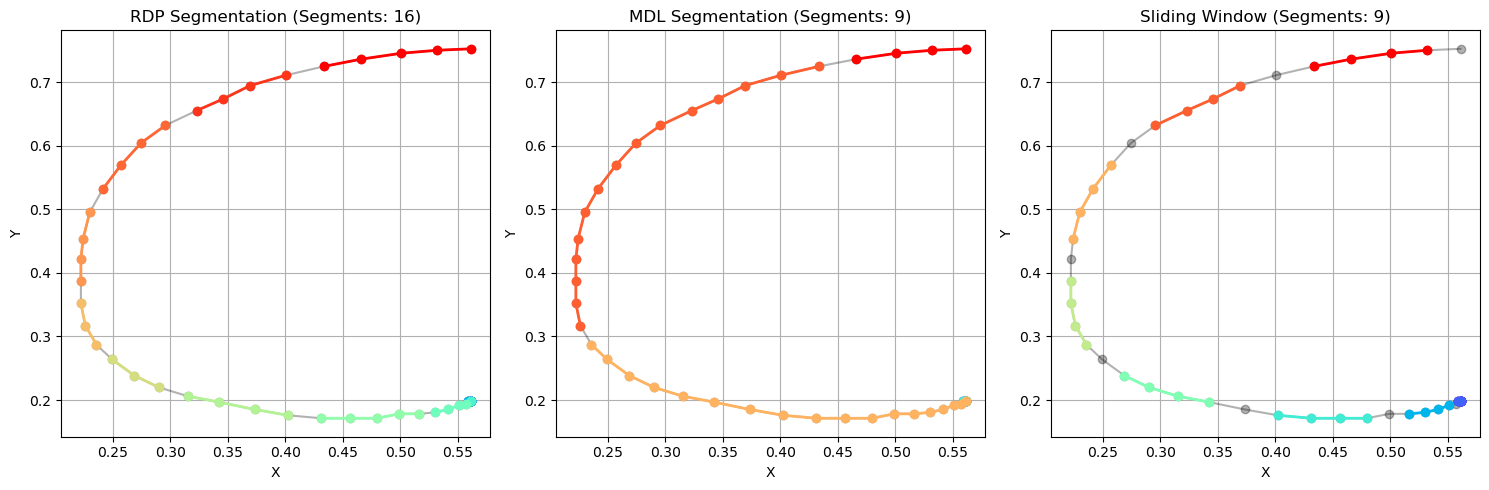

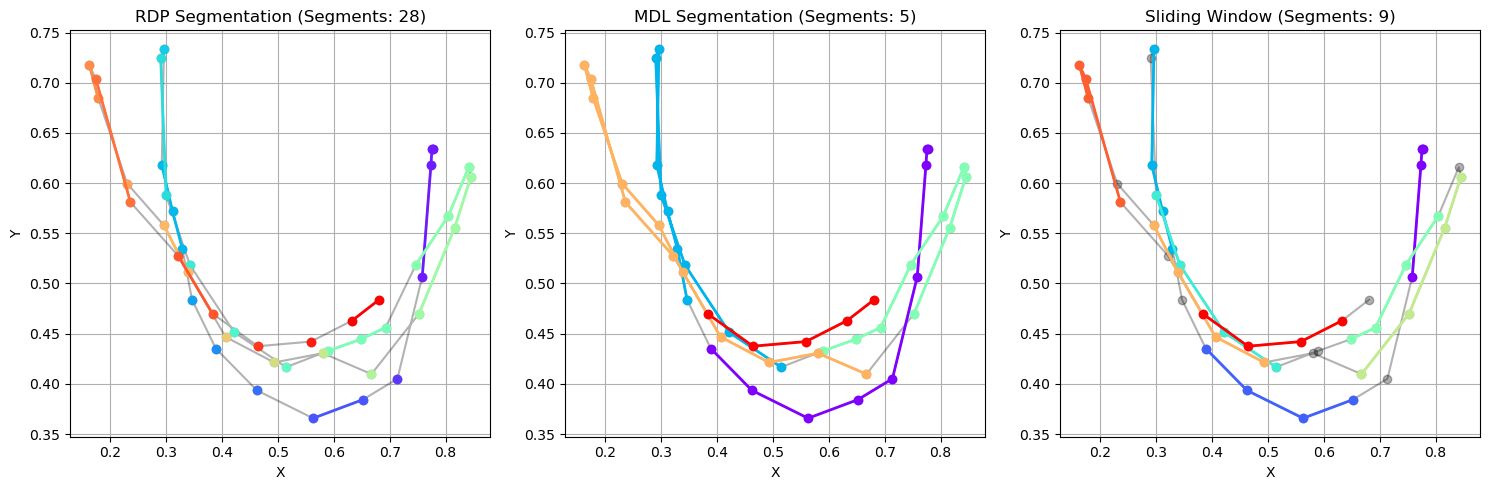

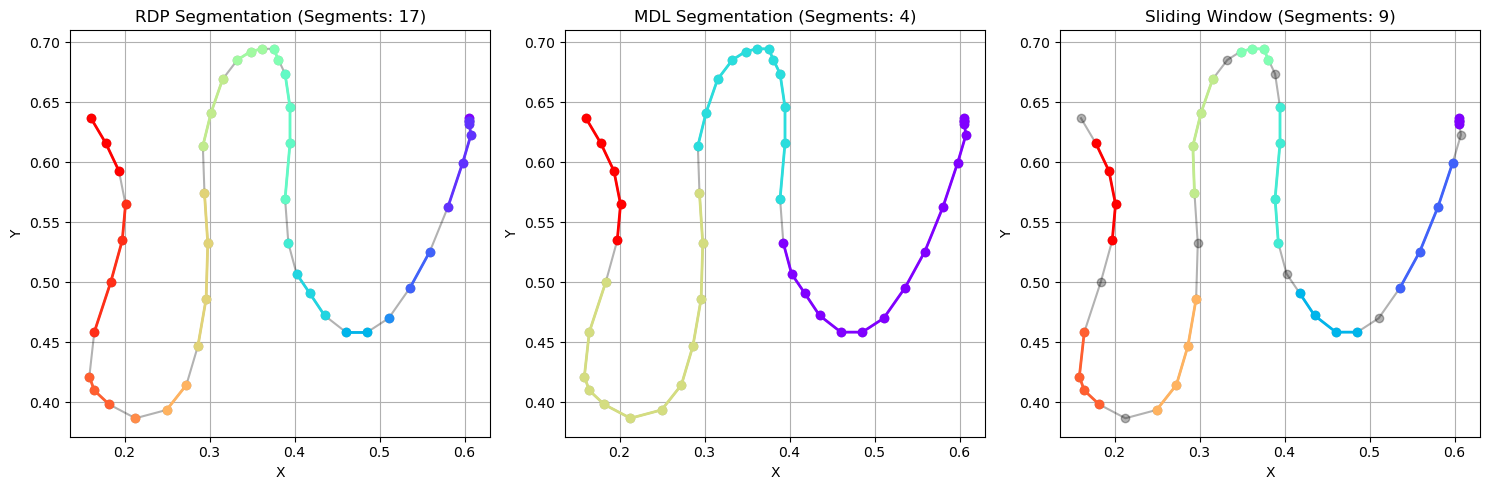

In [61]:
# Get a sample trajectory
sample_idx = 1
sample_traj = small_test.trajs[sample_idx]
sample_label = small_test.labels[sample_idx]

for idx in range(len(test.trajs)):
    traj = test.trajs[idx]
    # Extract points
    points = traj.r
    # points = sample_traj.r
    x = [p[0] for p in points]
    y = [p[1] for p in points]

    # Apply different segmentation methods
    rdp_segments = rdp_segmentation(points, epsilon=0.01)
    mdl_segments = mdl_segmentation(points, epsilon=0.8)
    sliding_segments = sliding_window_segmentation(points, step=5, percentage=10)
    # random_segments = random_segmentation(points, num_segments=5)

    # Prepare subplots for visualization
    # fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs = axs.flatten()

    # Helper function to plot segments
    def plot_segments(ax, segments, method_name):
        # Plot original trajectory
        ax.plot(x, y, "k-o", alpha=0.3, label="Original")

        # Plot segments
        colors = plt.cm.rainbow(np.linspace(0, 1, len(segments)))
        for i, segment in enumerate(segments):
            segment_x = [p[0] for p in segment]
            segment_y = [p[1] for p in segment]
            ax.plot(segment_x, segment_y, "-o", color=colors[i], linewidth=2)

        ax.set_title(f"{method_name} (Segments: {len(segments)})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid(True)


    # Plot each segmentation method
    plot_segments(axs[0], rdp_segments, "RDP Segmentation")
    plot_segments(axs[1], mdl_segments, "MDL Segmentation")
    plot_segments(axs[2], sliding_segments, "Sliding Window")
    # plot_segments(axs[3], random_segments, "Random Segmentation")

    plt.tight_layout()
    plt.show()

## Compare Different Perturbation Methods


TrajectoryGenerator.forward() missing 2 required positional arguments: 'obs_traj_rel' and 'seq_start_end'


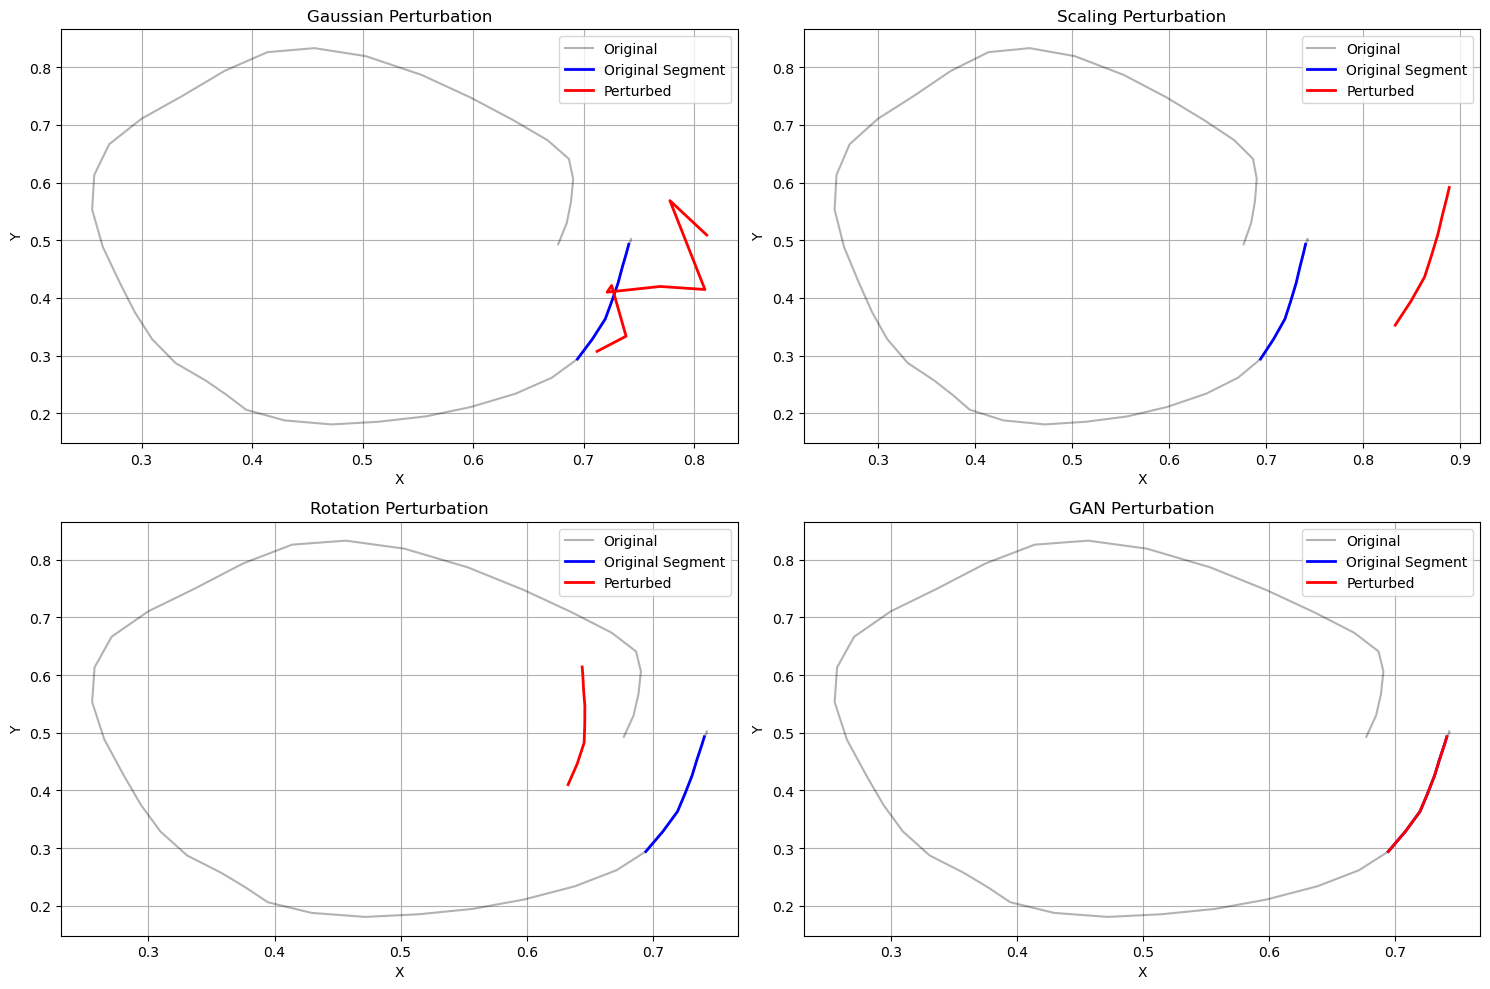

In [7]:
# Choose one segmentation method
segments = rdp_segments

# Choose one segment to perturb
segment_to_perturb_idx = 3
segment_to_perturb = segments[segment_to_perturb_idx]

# Apply different perturbation methods
gaussian_perturbed = gaussian_perturbation(segment_to_perturb, mean=0, std=0.2, scale=0.2)
scaling_perturbed = scaling_perturbation(segment_to_perturb)
rotation_perturbed = rotation_perturbation(segment_to_perturb)
gan_perturbed = gan_perturbation(segment_to_perturb, scale=0.01)

# Prepare subplots for visualization
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Helper function to plot perturbed segment
def plot_perturbation(ax, perturbed_segment, method_name):
    # Plot original trajectory
    ax.plot(x, y, "k-", alpha=0.3, label="Original")

    # Plot original segment
    segment_x = [p[0] for p in segment_to_perturb]
    segment_y = [p[1] for p in segment_to_perturb]
    ax.plot(segment_x, segment_y, "b-", linewidth=2, label="Original Segment")

    # Plot perturbed segment
    perturbed_x = [p[0] for p in perturbed_segment]
    perturbed_y = [p[1] for p in perturbed_segment]
    ax.plot(perturbed_x, perturbed_y, "r-", linewidth=2, label="Perturbed")

    ax.set_title(method_name)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.grid(True)

# Plot each perturbation method
plot_perturbation(axs[0,0], gaussian_perturbed, "Gaussian Perturbation")
plot_perturbation(axs[0,1], scaling_perturbed, "Scaling Perturbation")
plot_perturbation(axs[1,0], rotation_perturbed, "Rotation Perturbation")
plot_perturbation(axs[1,1], gan_perturbed, "GAN Perturbation")

plt.tight_layout()
plt.show()

## Run Experiments with Different Methods


In [8]:
# Define the segmentation and perturbation functions to compare
segment_funcs = [rdp_segmentation]
perturbation_funcs = [gaussian_perturbation, scaling_perturbation, rotation_perturbation, gan_perturbation]

# Create a log directory
import os

log_dir = "comparison_results"
os.makedirs(log_dir, exist_ok=True)

# Run experiments on a small subset for demonstration
print("Running experiments with different methods...")
run_experiments(small_test, segment_funcs, perturbation_funcs, model, log_dir=log_dir)

20:50:10 [INFO] Running experiment with rdp_segmentation and gaussian_perturbation
20:50:10 [DEBUG] Starting explanation process...


Running experiments with different methods...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


20:50:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:17 [INFO] Finished explanation process.
20:50:17 [DEBUG] Starting get_Y process...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


20:50:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1, 15)
20:50:17 [DEBUG] Starting get_Y_eval_sorted process...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


20:50:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(28, 15)
20:50:17 [DEBUG] Starting get_Y process...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


20:50:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1, 15)
20:50:17 [DEBUG] Finished get_Y_eval_sorted process.
20:50:17 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_gaussian_perturbation_results.csv: [0, 'traj_4d7c99f5', 1, 1.0, 'ok']
2025-10-21 20:50:17 - Total RAM: 13.86 GB | Used: 68.0%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:18 [WARNING] Only one class detected, skipping explanation.
20:50:18 [INFO] Trajectory 1: classification unchanged


[INFO] Row saved to comparison_results\rdp_segmentation_gaussian_perturbation_results.csv: [1, 'traj_592424a1', 0, 0.0, 'ok']


20:50:18 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


20:50:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:18 [WARNING] Only one class detected, skipping explanation.
20:50:18 [INFO] Trajectory 2: classification unchanged
20:50:18 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_gaussian_perturbation_results.csv: [2, 'traj_63a63c8e', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:19 [WARNING] Only one class detected, skipping explanation.
20:50:19 [INFO] Trajectory 3: classification unchanged
20:50:19 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_gaussian_perturbation_results.csv: [3, 'traj_19043dae', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:20 [WARNING] Only one class detected, skipping explanation.
20:50:20 [INFO] Trajectory 4: classification unchanged
20:50:20 [INFO] Results saved to comparison_results\rdp_segmentation_gaussian_perturbation_results.csv
20:50:20 [INFO] Running experiment with rdp_segmentation and scaling_perturbation
20:50:20 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_gaussian_perturbation_results.csv: [4, 'traj_85d42c6c', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:20 [WARNING] Only one class detected, skipping explanation.
20:50:20 [INFO] Trajectory 0: classification unchanged
20:50:20 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_scaling_perturbation_results.csv: [0, 'traj_4d7c99f5', 0, 0.0, 'ok']
2025-10-21 20:50:20 - Total RAM: 13.86 GB | Used: 68.2%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:21 [WARNING] Only one class detected, skipping explanation.
20:50:21 [INFO] Trajectory 1: classification unchanged
20:50:21 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_scaling_perturbation_results.csv: [1, 'traj_592424a1', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:21 [WARNING] Only one class detected, skipping explanation.
20:50:21 [INFO] Trajectory 2: classification unchanged
20:50:21 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_scaling_perturbation_results.csv: [2, 'traj_63a63c8e', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:22 [WARNING] Only one class detected, skipping explanation.
20:50:22 [INFO] Trajectory 3: classification unchanged
20:50:22 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_scaling_perturbation_results.csv: [3, 'traj_19043dae', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:23 [WARNING] Only one class detected, skipping explanation.
20:50:23 [INFO] Trajectory 4: classification unchanged


[INFO] Row saved to comparison_results\rdp_segmentation_scaling_perturbation_results.csv: [4, 'traj_85d42c6c', 0, 0.0, 'ok']


20:50:23 [INFO] Results saved to comparison_results\rdp_segmentation_scaling_perturbation_results.csv
20:50:23 [INFO] Running experiment with rdp_segmentation and rotation_perturbation
20:50:23 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:23 [WARNING] Only one class detected, skipping explanation.
20:50:23 [INFO] Trajectory 0: classification unchanged
20:50:23 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_rotation_perturbation_results.csv: [0, 'traj_4d7c99f5', 0, 0.0, 'ok']
2025-10-21 20:50:23 - Total RAM: 13.86 GB | Used: 68.2%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:24 [WARNING] Only one class detected, skipping explanation.
20:50:24 [INFO] Trajectory 1: classification unchanged
20:50:24 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_rotation_perturbation_results.csv: [1, 'traj_592424a1', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:25 [WARNING] Only one class detected, skipping explanation.
20:50:25 [INFO] Trajectory 2: classification unchanged
20:50:25 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_rotation_perturbation_results.csv: [2, 'traj_63a63c8e', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:25 [WARNING] Only one class detected, skipping explanation.
20:50:25 [INFO] Trajectory 3: classification unchanged
20:50:25 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_rotation_perturbation_results.csv: [3, 'traj_19043dae', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


20:50:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:26 [WARNING] Only one class detected, skipping explanation.
20:50:26 [INFO] Trajectory 4: classification unchanged
20:50:26 [INFO] Results saved to comparison_results\rdp_segmentation_rotation_perturbation_results.csv
20:50:26 [INFO] Running experiment with rdp_segmentation and gan_perturbation


[INFO] Row saved to comparison_results\rdp_segmentation_rotation_perturbation_results.csv: [4, 'traj_85d42c6c', 0, 0.0, 'ok']


20:50:26 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:27 [WARNING] Only one class detected, skipping explanation.
20:50:27 [INFO] Trajectory 0: classification unchanged
20:50:27 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_gan_perturbation_results.csv: [0, 'traj_4d7c99f5', 0, 0.0, 'ok']
2025-10-21 20:50:27 - Total RAM: 13.86 GB | Used: 68.1%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


20:50:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:27 [WARNING] Only one class detected, skipping explanation.
20:50:27 [INFO] Trajectory 1: classification unchanged


[INFO] Row saved to comparison_results\rdp_segmentation_gan_perturbation_results.csv: [1, 'traj_592424a1', 0, 0.0, 'ok']


20:50:28 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


20:50:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:28 [WARNING] Only one class detected, skipping explanation.
20:50:28 [INFO] Trajectory 2: classification unchanged


[INFO] Row saved to comparison_results\rdp_segmentation_gan_perturbation_results.csv: [2, 'traj_63a63c8e', 0, 0.0, 'ok']


20:50:28 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


20:50:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:29 [WARNING] Only one class detected, skipping explanation.
20:50:29 [INFO] Trajectory 3: classification unchanged
20:50:29 [DEBUG] Starting explanation process...


[INFO] Row saved to comparison_results\rdp_segmentation_gan_perturbation_results.csv: [3, 'traj_19043dae', 0, 0.0, 'ok']
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


20:50:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 15)
20:50:29 [WARNING] Only one class detected, skipping explanation.
20:50:29 [INFO] Trajectory 4: classification unchanged
20:50:29 [INFO] Results saved to comparison_results\rdp_segmentation_gan_perturbation_results.csv


[INFO] Row saved to comparison_results\rdp_segmentation_gan_perturbation_results.csv: [4, 'traj_85d42c6c', 0, 0.0, 'ok']


## Analyze Results


Found 6 result files


Method  Avg Precision  Change %  Count
0  mdl_segmentation_gaussian_perturbation            1.0     0.000     25
1  mdl_segmentation_rotation_perturbation            1.0     0.000     25
2       rdp_segmentation_gan_perturbation            1.0     0.000    132
3  rdp_segmentation_gaussian_perturbation            1.0     8.125    160
4  rdp_segmentation_rotation_perturbation            1.0     0.000    157
5   rdp_segmentation_scaling_perturbation            1.0     0.000    132

<Figure size 1200x600 with 0 Axes>

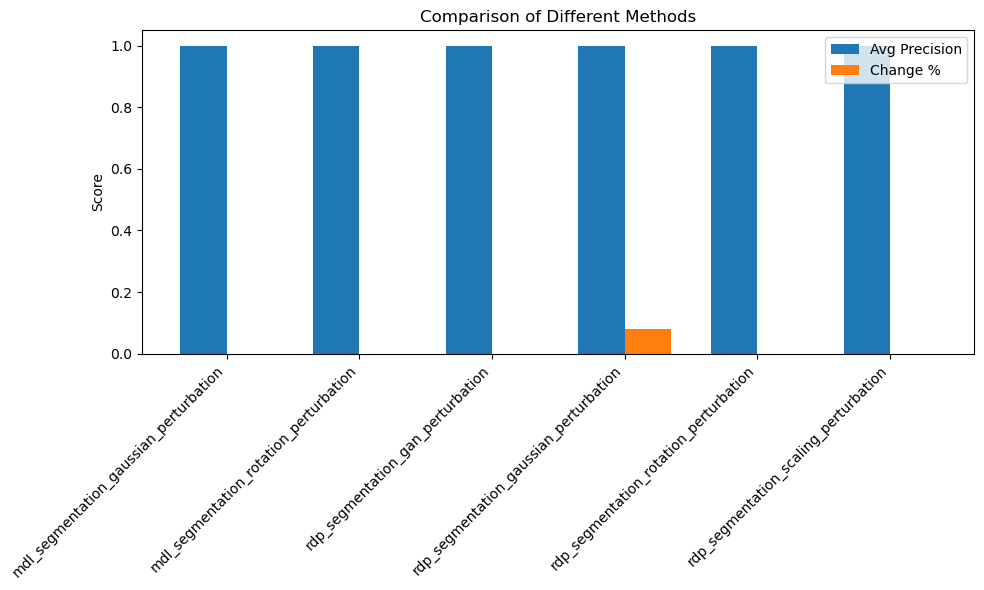

In [9]:
# Load and analyze results
import pandas as pd
import glob

# Find all result files
result_files = glob.glob(os.path.join(log_dir, "*.csv"))
print(f"Found {len(result_files)} result files")

# Load results into DataFrames
results_data = {}
for file_path in result_files:
    method_name = os.path.basename(file_path).replace("_results.csv", "")
    results_data[method_name] = pd.read_csv(file_path)

# Calculate average precision score and change percentage for each method
summary = []
for method, df in results_data.items():
    df["precision_score"] = [val == "ok" for val in df["precision_score"]]
    avg_precision = df["precision_score"].mean()
    change_pct = df["change"].mean() * 100
    summary.append(
        {
            "Method": method,
            "Avg Precision": avg_precision,
            "Change %": change_pct,
            "Count": len(df),
        }
    )

# Display summary
summary_df = pd.DataFrame(summary)
display(summary_df)

# Plot results
plt.figure(figsize=(12, 6))
_x = np.arange(len(summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    _x - width / 2,
    [item["Avg Precision"] for item in summary],
    width,
    label="Avg Precision",
)
ax.bar(
    _x + width / 2, [item["Change %"] / 100 for item in summary], width, label="Change %"
)

ax.set_ylabel("Score")
ax.set_title("Comparison of Different Methods")
ax.set_xticks(_x)
ax.set_xticklabels([item["Method"] for item in summary])
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()